# Final Project (Fall 2024)

**Date:** December 7th, 2024

**Team Members:**

* Brianna Huang
* Jacky Choi
* Cindy (Yongxue) Tao



# Background

As of May 2024, \$1.5 million is the average cost of a home in the Bay Area. Compared to the national average cost at around $420k, the Bay Area is known to be one of the most expensive housing markets in the past few decades. Certain rumors such as the dotcom bubble, good weather, or even just general demand for living spaces have been spreading leaving many people to believe these are the main causes of the ever growing prices. Today, we will deeply discover the main drivers of this expensive housing market and make predictions of future expensive housing markets with big data analytics.

# Setup and Libraries

In [ ]:
# Import Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import geopandas as gpd
import folium
from folium.plugins import HeatMap
from folium import plugins
from branca.colormap import linear
from shapely.wkt import loads
from shapely.geometry import MultiPolygon, Polygon
import branca.colormap as cm
import requests
from requests.structures import CaseInsensitiveDict
from multiprocessing import Pool

In [ ]:
#Stop us from getting annoying warnings that show up at the output
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)


# Data Downloading

### User Authentication & Data Downloading Function Definition

In [ ]:
# Same method as the sample project
# download data set from server
# authenticate the user
from google.colab import auth
auth.authenticate_user()
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')
import io
import os
from googleapiclient.http import MediaIoBaseDownload

def download_file(fn, file_id):
    request = drive_service.files().get_media(fileId=file_id)
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
        # _ is a placeholder for a progress object that we ignore.
        # (Our file is small, so we skip reporting progress.)
        _, done = downloader.next_chunk()
    downloaded.seek(0)
    folder = fn.split('/')
    if len(folder) > 1:
        os.makedirs(folder[0], exist_ok=True)
    with open(fn, 'wb') as f:
        f.write(downloaded.read())

### Download Datasets for the Project

Datasets that we decided to use are as following:


*   realtor-data.csv
*   cost-of-living-us.csv
*   cites-to-county.csv
*   salary-sf.csv
*   prop-21.csv
*   air-pollution.csv
*   us-city-avg-temp.csv
*   us-tech-companies.csv
*   ca-housing.csv
*   sf-precincts.csv
*   zoning.csv
*   bay-area.csv
*   cal_cities_lat_long.csv




In [ ]:
id_to_fn ={
'1exLzjvcGJZp6XAng8S0EbQQKyaOUJVmP': 'realtor-data.csv',
'1Z9Cy3Aj_i65ME8f0ihVl0zjl-frD8ERI': 'property-tax-ca.csv',
'1VGEy1kxOa3PF0Iej-MaLE_TdLes0AP1E': 'cost-of-living-us.csv',
'1UR1u44mE-aS-80sVhQLm8GPcoEQWDhP1': 'cites-to-county.csv',
'1m8njt-xQ8JtZVoAH8AXLAVgJs8NNSwf6': 'salary-sf.csv',
'1mswxPlKlVyXE6fBH4edceDDco5dx9Fkg': 'prop-21.csv',
'1YtscVKKMSIiF3xtPCQwIefhv3qzy9HOJ': 'air-pollution.csv',
'19qamnetMVt52l--HBy7dQWUwYX4T26EF': 'us-city-avg-temp.csv',
'1kdiBtllIfkuEU3KqaxVaEUAIo9Yg5RIc': 'us-tech-companies.csv',
'1IhKmR7Yo5IbE9RaGoMGsRrBOt4jhNieZ': 'ca-housing.csv',
'1Z13dlz_t9JRAJl8vIcwqc0nzDePUi_KM': 'sf-precincts.csv',
'1X4EcSaLYj-Nhe9hUYERbfpb-wZ1XQdzz': 'zoning.csv',
'1f4p6-aJma_wBI16rXOpIf8aCa5TkW-Zi': 'bay-area.csv',
'1hiopBzMSlO4sCi-XI3n4wsp4YkgYZq0f': 'cal_cities_lat_long.csv'
}

# download all files into the vm
for fid, fn in id_to_fn.items():
    print("Downloading %s from %s" % (fn, fid))
    download_file(fn, fid)

# Dataset Cleaning and Preparation

### Realtor Data Extraction & Cleaning



*   We extract data from realtor containing house data all around US
*   We further extracted the data that belongs to the San Francisco and California


In [ ]:
# Read datasets
realtor_df = pd.read_csv('realtor-data.csv')
realtor_df.head(3)

brokered_by    status     price  bed  bath  acre_lot     street  \
0     103378.0  for_sale  105000.0  3.0   2.0      0.12  1962661.0   
1      52707.0  for_sale   80000.0  4.0   2.0      0.08  1902874.0   
2     103379.0  for_sale   67000.0  2.0   1.0      0.15  1404990.0   

         city        state  zip_code  house_size prev_sold_date  
0    Adjuntas  Puerto Rico     601.0       920.0            NaN  
1    Adjuntas  Puerto Rico     601.0      1527.0            NaN  
2  Juana Diaz  Puerto Rico     795.0       748.0            NaN

In [ ]:
# Number of rows in the dateset
realtor_df.shape[0]

2226382

In [ ]:
# Count num of unique cities
realtor_df['city'].nunique()

20098

In [ ]:
# Gather all the bay area zip code
bay_area_zipcodes = {
    'San Francisco': [94102, 94103, 94104, 94105, 94107, 94108, 94109, 94110, 94111, 94112, 94114, 94115, 94116, 94117, 94118, 94121, 94122, 94123, 94124, 94127, 94131, 94132, 94133, 94134],
    'Oakland': [94601, 94602, 94603, 94605, 94606, 94607, 94608, 94609, 94610, 94611, 94612, 94618, 94619, 94621],
    'San Jose': [95101, 95110, 95111, 95112, 95113, 95116, 95117, 95118, 95119, 95120, 95121, 95122, 95123, 95124, 95125, 95126, 95127, 95128, 95129, 95130, 95131, 95132, 95133, 95134, 95135, 95136, 95138, 95139, 95140],
    'Berkeley': [94701, 94702, 94703, 94704, 94705, 94706, 94707, 94708, 94709, 94710],
    'Fremont': [94536, 94537, 94538, 94539, 94555],
    'Union City': [94587],
    'Palo Alto': [94301, 94303, 94304, 94305, 94306],
    'Mountain View': [94035, 94039, 94040, 94041, 94043],
    'Santa Clara': [95050, 95051, 95052, 95053, 95054, 95055],
    'Hayward': [94540, 94541, 94542, 94543, 94544],
    'Dublin': [94568],
    'Pleasanton': [94566],
    'Livermore': [94550, 94551],
    'San Mateo': [94401, 94402, 94403, 94404, 94497],
    'Richmond': [94801, 94802, 94804, 94805, 94806, 94807, 94808],
    'Concord': [94518, 94519, 94520, 94521, 94522],
}

# Combine all ZIP codes into one list
combined_zipcodes = [zipcode for zipcodes in bay_area_zipcodes.values() for zipcode in zipcodes]

# Print the combined list
print(combined_zipcodes)

[94102, 94103, 94104, 94105, 94107, 94108, 94109, 94110, 94111, 94112, 94114, 94115, 94116, 94117, 94118, 94121, 94122, 94123, 94124, 94127, 94131, 94132, 94133, 94134, 94601, 94602, 94603, 94605, 94606, 94607, 94608, 94609, 94610, 94611, 94612, 94618, 94619, 94621, 95101, 95110, 95111, 95112, 95113, 95116, 95117, 95118, 95119, 95120, 95121, 95122, 95123, 95124, 95125, 95126, 95127, 95128, 95129, 95130, 95131, 95132, 95133, 95134, 95135, 95136, 95138, 95139, 95140, 94701, 94702, 94703, 94704, 94705, 94706, 94707, 94708, 94709, 94710, 94536, 94537, 94538, 94539, 94555, 94587, 94301, 94303, 94304, 94305, 94306, 94035, 94039, 94040, 94041, 94043, 95050, 95051, 95052, 95053, 95054, 95055, 94540, 94541, 94542, 94543, 94544, 94568, 94566, 94550, 94551, 94401, 94402, 94403, 94404, 94497, 94801, 94802, 94804, 94805, 94806, 94807, 94808, 94518, 94519, 94520, 94521, 94522]


In [ ]:
# Filter all the real estate in California
california_df = realtor_df[(realtor_df['state'] == 'California')]

# Filter all the real estate in the Bay Area
bay_area_df = realtor_df[(realtor_df['state'] == 'California') & (realtor_df['zip_code'].isin(combined_zipcodes))]
bay_area_df.head()

brokered_by    status      price  bed  bath  acre_lot     street  \
1322526      53484.0  for_sale  1699888.0  3.0   2.0      0.14   841908.0   
1322528      52915.0  for_sale  1499000.0  6.0   3.0      0.23   242080.0   
1322530      13926.0  for_sale  1280000.0  3.0   2.0      0.17  1818716.0   
1322534      16829.0  for_sale   899888.0  2.0   2.0       NaN   102119.0   
1322535      87831.0  for_sale  1168000.0  2.0   2.0      0.04    86809.0   

                   city       state  zip_code  house_size prev_sold_date  
1322526        San Jose  California   95130.0      1467.0     2013-06-25  
1322528  East Palo Alto  California   94303.0      2456.0     2015-01-09  
1322530       San Mateo  California   94401.0      1057.0     2019-06-20  
1322534     Foster City  California   94404.0      1349.0     1989-03-14  
1322535     Foster City  California   94404.0       980.0     1984-04-13

In [ ]:
# Number of rows in the bay area dateset
bay_area_df.shape[0]

20534

In [ ]:
# Clean the data by dropping the na
california_df.dropna(subset=['zip_code', 'city'])
bay_area_df.dropna(subset=['zip_code', 'city'])
california_df.reset_index(drop=True, inplace=True)
bay_area_df.reset_index(drop=True, inplace=True)
california_df.head()

brokered_by    status         price  bed  bath  acre_lot     street  \
0     102093.0  for_sale  3.000000e+06  7.0   6.0       NaN  1760549.0   
1      23826.0  for_sale  2.147484e+09  2.0   2.0      0.12    11355.0   
2      98034.0  for_sale  1.000000e+07  NaN   NaN    123.97        NaN   
3      16829.0  for_sale  3.280000e+05  3.0   3.0       NaN   915973.0   
4      17458.0  for_sale  1.990000e+05  NaN   NaN      5.10     2937.0   

                 city       state  zip_code  house_size prev_sold_date  
0             Balzola  California       0.0      6889.0            NaN  
1       International  California       NaN       885.0            NaN  
2  Playa de Novillero  California       NaN         NaN            NaN  
3        Quintana Roo  California       NaN         NaN            NaN  
4             Milford  California   96121.0         NaN            NaN

In [ ]:
# Number of rows in the California dataset
california_df.shape[0]

227215

### Salaries San Francisco Extraction & Cleaning



*   We explore the San Francisco salary dataset



In [ ]:
# Read in the San Francisco dataset
salaries_sf_df = pd.read_csv('salary-sf.csv')
salaries_sf_df.head()

<ipython-input-147-0fa18458e502>:2: DtypeWarning:

Columns (3,4,5,6,12) have mixed types. Specify dtype option on import or set low_memory=False.



Id       EmployeeName                                        JobTitle  \
0   1     NATHANIEL FORD  GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY   
1   2       GARY JIMENEZ                 CAPTAIN III (POLICE DEPARTMENT)   
2   3     ALBERT PARDINI                 CAPTAIN III (POLICE DEPARTMENT)   
3   4  CHRISTOPHER CHONG            WIRE ROPE CABLE MAINTENANCE MECHANIC   
4   5    PATRICK GARDNER    DEPUTY CHIEF OF DEPARTMENT,(FIRE DEPARTMENT)   

     BasePay OvertimePay   OtherPay Benefits   TotalPay  TotalPayBenefits  \
0  167411.18         0.0  400184.25      NaN  567595.43         567595.43   
1  155966.02   245131.88  137811.38      NaN  538909.28         538909.28   
2  212739.13   106088.18    16452.6      NaN  335279.91         335279.91   
3    77916.0    56120.71   198306.9      NaN  332343.61         332343.61   
4   134401.6      9737.0  182234.59      NaN  326373.19         326373.19   

   Year  Notes         Agency Status  
0  2011    NaN  San Francisco    NaN  
1  2011    NaN  San Francisco    NaN  
2  2011    NaN  San Francisco    NaN  
3  2011    NaN  San Francisco    NaN  
4  2011    NaN  San Francisco    NaN

In [ ]:
# Number of rows in the San Francisco dataset
salaries_sf_df.shape[0]

148654

In [ ]:
# Clean the dataset by dropping the na and removing the duplicates
salaries_sf_df.fillna({'BasePay': 0, 'TotalPay': 0}, inplace = True)
salaries_sf_df.drop_duplicates(inplace=True)
salaries_sf_df.head()

Id       EmployeeName                                        JobTitle  \
0   1     NATHANIEL FORD  GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY   
1   2       GARY JIMENEZ                 CAPTAIN III (POLICE DEPARTMENT)   
2   3     ALBERT PARDINI                 CAPTAIN III (POLICE DEPARTMENT)   
3   4  CHRISTOPHER CHONG            WIRE ROPE CABLE MAINTENANCE MECHANIC   
4   5    PATRICK GARDNER    DEPUTY CHIEF OF DEPARTMENT,(FIRE DEPARTMENT)   

     BasePay OvertimePay   OtherPay Benefits   TotalPay  TotalPayBenefits  \
0  167411.18         0.0  400184.25      NaN  567595.43         567595.43   
1  155966.02   245131.88  137811.38      NaN  538909.28         538909.28   
2  212739.13   106088.18    16452.6      NaN  335279.91         335279.91   
3    77916.0    56120.71   198306.9      NaN  332343.61         332343.61   
4   134401.6      9737.0  182234.59      NaN  326373.19         326373.19   

   Year  Notes         Agency Status  
0  2011    NaN  San Francisco    NaN  
1  2011    NaN  San Francisco    NaN  
2  2011    NaN  San Francisco    NaN  
3  2011    NaN  San Francisco    NaN  
4  2011    NaN  San Francisco    NaN

### Cities to County Data Extraction & Cleaning



*   We added a cities to country dataset to help with merging some of the dataset that only had cities or only had county information



In [ ]:
# Read and clean the cities to county dataset
cities_to_county_df = pd.read_csv('cites-to-county.csv')
cities_to_county_df = cities_to_county_df[['city','county_name']]
cities_to_county_df = cities_to_county_df.drop_duplicates(subset=['city'])
print(cities_to_county_df.shape[0])
cities_to_county_df.head()

20855


city  county_name
0     New York       Queens
1  Los Angeles  Los Angeles
2      Chicago         Cook
3        Miami   Miami-Dade
4      Houston       Harris

### Cost of Living Data Extraction & Cleaning



*   We added cost of living dataset to see if the cost of living has any relationship in helping predict the housing price
*   We also extracted the cost of living for California



In [ ]:
# Read datasets
cost_of_living_us_df = pd.read_csv('cost-of-living-us.csv', on_bad_lines='skip', low_memory=False)
cost_of_living_us_df.head()

case_id state  isMetro            areaname          county  \
0        1    AL     True  Montgomery, AL MSA  Autauga County   
1        1    AL     True  Montgomery, AL MSA  Autauga County   
2        1    AL     True  Montgomery, AL MSA  Autauga County   
3        1    AL     True  Montgomery, AL MSA  Autauga County   
4        1    AL     True  Montgomery, AL MSA  Autauga County   

  family_member_count  housing_cost    food_cost  transportation_cost  \
0                1p0c    8505.72876   3454.91712          10829.16876   
1                1p1c   12067.50240   5091.70788          11588.19288   
2                1p2c   12067.50240   7460.20308          12361.77720   
3                1p3c   15257.15040   9952.23924          13452.18600   
4                1p4c   15257.15040  12182.21400          13744.59840   

   healthcare_cost  other_necessities_cost  childcare_cost        taxes  \
0       5737.47984              4333.81344          0.0000   6392.94504   
1       8659.55640              6217.45896       6147.8298   7422.07836   
2      11581.63260              7075.65816      15824.6940   9769.56228   
3      14503.70760              9134.35620      18802.1892  13101.70320   
4      17425.78560              9942.36396      18802.1892  13469.21880   

    total_cost  median_family_income  
0   39254.0532          73010.414062  
1   57194.3256          73010.414062  
2   76141.0308          73010.414062  
3   94203.5328          73010.414062  
4  100823.5200          73010.414062

In [ ]:
# Number of rows in cost of living dataset
cost_of_living_us_df.shape[0]

31430

In [ ]:
# Drop the na and set isMetro to 0/1
cost_of_living_us_df = cost_of_living_us_df.dropna()
cost_of_living_us_df['isMetro'] = cost_of_living_us_df['isMetro'].apply(lambda x: 1 if x else 0)
cost_of_living_us_df.head()

case_id state  isMetro            areaname          county  \
0        1    AL        1  Montgomery, AL MSA  Autauga County   
1        1    AL        1  Montgomery, AL MSA  Autauga County   
2        1    AL        1  Montgomery, AL MSA  Autauga County   
3        1    AL        1  Montgomery, AL MSA  Autauga County   
4        1    AL        1  Montgomery, AL MSA  Autauga County   

  family_member_count  housing_cost    food_cost  transportation_cost  \
0                1p0c    8505.72876   3454.91712          10829.16876   
1                1p1c   12067.50240   5091.70788          11588.19288   
2                1p2c   12067.50240   7460.20308          12361.77720   
3                1p3c   15257.15040   9952.23924          13452.18600   
4                1p4c   15257.15040  12182.21400          13744.59840   

   healthcare_cost  other_necessities_cost  childcare_cost        taxes  \
0       5737.47984              4333.81344          0.0000   6392.94504   
1       8659.55640              6217.45896       6147.8298   7422.07836   
2      11581.63260              7075.65816      15824.6940   9769.56228   
3      14503.70760              9134.35620      18802.1892  13101.70320   
4      17425.78560              9942.36396      18802.1892  13469.21880   

    total_cost  median_family_income  
0   39254.0532          73010.414062  
1   57194.3256          73010.414062  
2   76141.0308          73010.414062  
3   94203.5328          73010.414062  
4  100823.5200          73010.414062

In [ ]:
# Set the cost of living for California
cost_of_living_ca_df = cost_of_living_us_df[cost_of_living_us_df['state']=='CA']

### Bay area cities extraction & cleaning



*   We added a bay area dataset to help retrieve all the cities in the bay area



In [ ]:
# Read and get list of all Bay Area Cities
bay_area_cities = pd.read_csv('bay-area.csv')
bay_area_cities = bay_area_cities.rename(columns={'country_code': 'Country', 'city_name': 'City' })
bay_area_cities_df = bay_area_cities[['Country', 'City']]
bay_area_cities_df.head(5)

Country      City
0      US    Acampo
1      US   Alameda
2      US     Alamo
3      US    Albany
4      US  Alhambra

### US Pollution Data extraction & cleaning




*   We extracted US Pollution dataset to see if the pollution level affects the housing market



In [ ]:
# Read air pollution data
air_pollution_df = pd.read_csv('air-pollution.csv')
air_pollution_df.head()

Country              City  AQI Value AQI Category  CO AQI Value  \
0  Russian Federation        Praskoveya         51     Moderate             1   
1              Brazil  Presidente Dutra         41         Good             1   
2               Italy   Priolo Gargallo         66     Moderate             1   
3              Poland         Przasnysz         34         Good             1   
4              France          Punaauia         22         Good             0   

  CO AQI Category  Ozone AQI Value Ozone AQI Category  NO2 AQI Value  \
0            Good               36               Good              0   
1            Good                5               Good              1   
2            Good               39               Good              2   
3            Good               34               Good              0   
4            Good               22               Good              0   

  NO2 AQI Category  PM2.5 AQI Value PM2.5 AQI Category  
0             Good               51           Moderate  
1             Good               41               Good  
2             Good               66           Moderate  
3             Good               20               Good  
4             Good                6               Good

In [ ]:
# Filter air pollution data to USA only into us_pollution_df
us_pollution_df = air_pollution_df[air_pollution_df['Country']=='United States of America'].copy()
us_pollution_df['Country'] = 'US'
# Only get the Country City and AQI Value column
us_pollution_df = us_pollution_df[['Country', 'City', 'AQI Value']]
us_pollution_df.head(5)

Country         City  AQI Value
5       US  Punta Gorda         54
18      US      Phoenix         72
30      US      Pontiac         77
35      US  Port Neches         34
37      US     Portales         77

In [ ]:
# Group by Bay area cities and AQI and another by non Bay Area Cities
aqi_bay_area_cities_df = us_pollution_df[us_pollution_df['City'].isin(bay_area_cities_df['City'])]
aqi_non_bay_area_cities_df = us_pollution_df[~us_pollution_df['City'].isin(bay_area_cities_df['City'])]
aqi_bay_area_cities_df = aqi_bay_area_cities_df[['City', 'AQI Value']]
aqi_non_bay_area_cities_df = aqi_non_bay_area_cities_df[['City', 'AQI Value']]
aqi_bay_area_cities_df

City  AQI Value
59      Green Valley         44
254          Antioch         76
385           Orinda         52
477         Richmond         76
488        Daly City         62
...              ...        ...
21285  Castro Valley         71
22035          Tracy         52
22436     El Cerrito         46
22775         Newark         67
22787        Fremont         52

[96 rows x 2 columns]

### US Tech Company Data extracting & cleaning



*   We extracted some big US tech company to predict if that impacts the housing market



In [ ]:
# Read USA tech companies
us_tech_companies_df = pd.read_csv('us-tech-companies.csv')
us_tech_companies_df.head(5)

Company Name    Industry                   Sector    HQ State  \
0             Apple Inc.  Technology     Consumer Electronics  California   
1  Microsoft Corporation  Technology  Software Infrastructure  Washington   
2      Alphabet (Google)  Technology  Software Infrastructure  California   
3                 Amazon  Technology     Software Application  Washington   
4     NVIDIA Corporation  Technology           Semiconductors  California   

   Founding Year  Annual Revenue 2022-2023 (USD in Billions)  \
0           1976                                      387.53   
1           1975                                      204.09   
2           1998                                      282.83   
3           1994                                      513.98   
4           1993                                       26.97   

   Market Cap (USD in Trillions) Stock Name  \
0                          2.520       AAPL   
1                          2.037       MSFT   
2                          1.350       GOOG   
3                          1.030       AMZN   
4                          0.653       NVDA   

   Annual Income Tax in 2022-2023 (USD in Billions)  Employee Size  
0                                            18.314         164000  
1                                            15.139         221000  
2                                            11.356         190234  
3                                            -3.217        1541000  
4                                             0.189          22473

### Temperatures extraction & cleaning



*   We extract some of the temperature information to predict if that impacts the housing market



In [ ]:
# Read major US city average monthly temp for past few decades
us_city_temp_avg_df = pd.read_csv('us-city-avg-temp.csv')
us_city_temp_avg_df.head(5)

time  albuquerque  anchorage    atlanta      boise     boston  \
0  1948-01-01    -0.440002  -5.979980   3.420013  -0.600006  -5.989990   
1  1948-02-01     1.649994  -9.000000   9.110016   0.130005  -4.350006   
2  1948-03-01     3.470001  -5.850006  13.640015   2.309998   2.410004   
3  1948-04-01    13.240021  -0.269989  18.660004   7.250000   8.130005   
4  1948-05-01    16.910004   6.730011  21.540009  11.860016  12.770020   

     buffalo  charlotte    chicago     dallas  ...   portland  rapid_city  \
0  -7.790008   2.390015  -7.339996   4.529999  ...   3.920013   -4.029999   
1  -4.549988   6.670013  -3.139984   8.589996  ...   4.029999   -5.549988   
2   1.160004  12.520020   2.950012  12.640015  ...   6.220001   -1.250000   
3   8.690002  17.279999  12.149994  21.869995  ...   8.100006    9.480011   
4  11.320007  20.619995  13.700012  23.800018  ...  12.230011   13.270020   

       reno   richmond  sacramento  salt_lake_city  san_antonio  \
0  0.250000   0.170013    9.610016       -2.919983     8.619995   
1 -3.160004   4.690002    8.679993       -1.850006    12.649994   
2 -2.100006  11.270020   10.160004       -1.179993    16.970001   
3  0.929993  15.209991   12.640015        6.790008    23.420013   
4  5.119995  19.500000   16.119995       11.800018    26.520020   

   san_francisco    seattle      tampa  
0      11.950012   4.380005  15.000000  
1      10.020020   4.260010  19.070007  
2      10.320007   6.450012  21.959991  
3      11.510010   8.130005  22.839996  
4      12.760010  12.119995  25.380005  

[5 rows x 36 columns]

In [ ]:
# Filter for Bay Area Cities and other cities
bay_area_cities_avg_temp_df = us_city_temp_avg_df[['time', 'san_francisco', 'san_antonio', 'sacramento', 'richmond']]
other_cities_avg_temp_df = us_city_temp_avg_df.drop(['san_francisco', 'san_antonio', 'sacramento', 'richmond'], axis=1)
bay_area_cities_avg_temp_df.head(5)

time  san_francisco  san_antonio  sacramento   richmond
0  1948-01-01      11.950012     8.619995    9.610016   0.170013
1  1948-02-01      10.020020    12.649994    8.679993   4.690002
2  1948-03-01      10.320007    16.970001   10.160004  11.270020
3  1948-04-01      11.510010    23.420013   12.640015  15.209991
4  1948-05-01      12.760010    26.520020   16.119995  19.500000

### Zoning Data extraction & cleaning

*   Following the adoption of the Regional Housing Need Assessment (RHNA), each jurisdiction is required to update its housing element to identify sites adequate to accommodate the number of units allocated to them

In [ ]:
# Read in the zone dataset
zoning = pd.read_csv('zoning.csv')
zoning=zoning.rename(columns={'jurisdict':'jurisdiction',
                       'locacres':'acreage',
                       'currunits':'units',
                       'allowden':'allowed_unit_density',
                       'desafford':'affordability',
                       'infcapcty': 'infrastructure_capacity',
                       'sitetype': 'site_status'})
zoning = zoning[['county', 'jurisdiction', 'zoning', 'acreage', 'units', 'allowed_unit_density', 'affordability', 'infrastructure_capacity', 'site_status']]
zoning = zoning.dropna(subset=['zoning'], axis=0)
zoning.head()

county   jurisdiction zoning   acreage  units allowed_unit_density  \
0     6013      Brentwood  PD-45  0.165491      0                  NaN   
14    6013       Martinez   R-10  0.230000      0                    1   
25    6075  San Francisco    UMU  0.045914      0                  NaN   
26    6075  San Francisco    UMU  0.045914      0                  NaN   
27    6075  San Francisco    NCT  0.183346      0                  NaN   

   affordability infrastructure_capacity site_status  
0            NaN                       Y    Approved  
14           NaN                       Y      Vacant  
25           NaN                     NaN      Vacant  
26           NaN                     NaN      Vacant  
27           NaN                     NaN      Vacant

In [ ]:
# Convert the zone code to type
zone_types = {
    'R': 'Residential',
    'C': 'Commercial',
    'P': 'Planned Development',
    'A': 'Agricultural',
    'T': 'Mixed-Use',
    'D': 'Downtown',
    'M': 'Industrial',
    'U': 'Urban',
    'N': 'Neighborhood Commercial'
}

def zone_code_to_type(zone):
    if pd.isna(zone):
        return 'Unknown'
    if any(c for c in zone if c.islower()):
        return zone
    c = zone[0]
    return zone_types.get(c, 'Other')

zoning['zoning_type'] = zoning['zoning'].apply(lambda x: zone_code_to_type(x))
zoning.head()

county   jurisdiction zoning   acreage  units allowed_unit_density  \
0     6013      Brentwood  PD-45  0.165491      0                  NaN   
14    6013       Martinez   R-10  0.230000      0                    1   
25    6075  San Francisco    UMU  0.045914      0                  NaN   
26    6075  San Francisco    UMU  0.045914      0                  NaN   
27    6075  San Francisco    NCT  0.183346      0                  NaN   

   affordability infrastructure_capacity site_status              zoning_type  
0            NaN                       Y    Approved      Planned Development  
14           NaN                       Y      Vacant              Residential  
25           NaN                     NaN      Vacant                    Urban  
26           NaN                     NaN      Vacant                    Urban  
27           NaN                     NaN      Vacant  Neighborhood Commercial

### Proposition 21 voter data (2020), SF precinct extraction & cleaning
*   Final: Yes 40.1%, No 59.9%

*   Pro: This would let cities pass limits on rent increases to protect California families who are one rent hike away from being driven out of their neighborhoods by corporate landlords. This will stop more homelessness and gentrification.

*   Anti: It would make it less profitable for builders to construct more housing, affordable or not, at a time when California has a massive housing shortage. It would also decrease revenue for city and state governments, already cash-strapped by the pandemic.

In [ ]:
# Read in the voter dataset
prop21 = pd.read_csv('prop-21.csv')

In [ ]:
# Rename the Unnamed 4 column to No%
prop21 = prop21.rename(columns={'Unnamed: 4': 'No%'})
prop21 = prop21[prop21['Precinct']!='Election Day']
prop21 = prop21[prop21['Precinct']!='Vote by Mail'].reset_index().drop(columns='index')

In [ ]:
# Update the Precinct column
for i in range(1, len(prop21), 2):
    precinct = prop21.iloc[i-1]['Precinct']
    prop21.at[i, 'Precinct'] = precinct
prop21 = prop21.dropna(axis=0)

In [ ]:
# Apply function to fix Precinct, Yes% and No% columns
prop21['Precinct'] = prop21['Precinct'].apply(lambda x: x.replace('PCT ', ''))
prop21['Yes%'] = prop21['Yes%'].apply(lambda x: float(x.strip('%'))/100)
prop21['No%'] = prop21['No%'].apply(lambda x: float(x.strip('%'))/100)

<ipython-input-167-eddc6e7e78ed>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-167-eddc6e7e78ed>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-167-eddc6e7e78ed>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# Split based on /
to_split = prop21[prop21['Precinct'].str.contains('/', na=False)]
inds_to_split = to_split.index
df_split = to_split['Precinct'].str.split('/', expand=True)

rows = []
for index, row in to_split.iterrows():
    for precinct in df_split.loc[index]:
        new_row = row.copy()
        new_row['Precinct'] = precinct
        rows.append(new_row)
new_df = pd.DataFrame(rows)

prop21 = prop21.drop(inds_to_split, axis=0)
prop21 = pd.concat([prop21, new_df])
prop21.head()

Precinct  Yes    Yes%   No     No% Total Votes
1      1101  265  0.5268  238  0.4732         503
3      1102  406  0.4667  464  0.5333         870
5      1103  395  0.4582  467  0.5418         862
9      1106  332  0.4890  347  0.5110         679
11     1107  340  0.5152  320  0.4848         660

In [ ]:
# Read in the San Francisco precinct data
sf_precincts = pd.read_csv('sf-precincts.csv')
sf_precincts = sf_precincts[['prec_2012', 'the_geom', 'neighrep']]
sf_precincts= sf_precincts.dropna(axis=0)
sf_precincts['prec_2012'] = sf_precincts['prec_2012'].astype(int).astype(str)
sf_precincts.head()

prec_2012                                           the_geom      neighrep
0      9151  MULTIPOLYGON (((-122.44730200045501 37.7823919...  LRL HTS/ANZA
1      9134  MULTIPOLYGON (((-122.4500920005295 37.78211700...  LRL HTS/ANZA
2      9152  MULTIPOLYGON (((-122.45300300019134 37.7749710...  LRL HTS/ANZA
3      7101  MULTIPOLYGON (((-122.45262399964557 37.7731060...    HAIGHT ASH
4      9133  MULTIPOLYGON (((-122.45629600039165 37.7813809...      RICHMOND

### California Housing extraction & cleaning



*   We extracted the California dataset to predict if any of the features on this dataset affect the housing market



In [ ]:
# Read in the California dataset and the number of rows
ca_housing = pd.read_csv('ca-housing.csv')
ca_housing.head()
len(ca_housing)

20640

In [ ]:
# Convert the proximity map to numbers
proximity_map = {
    'ISLAND':0,
    'NEAR OCEAN':1,
    'NEAR BAY': 2,
    '<1H OCEAN':3,
    'INLAND':4
}

ca_housing['ocean_proximity'] = ca_housing['ocean_proximity'].apply(lambda x: proximity_map[x])
ca_housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value  ocean_proximity  
0       322.0       126.0         8.3252            452600.0                2  
1      2401.0      1138.0         8.3014            358500.0                2  
2       496.0       177.0         7.2574            352100.0                2  
3       558.0       219.0         5.6431            341300.0                2  
4       565.0       259.0         3.8462            342200.0                2

In [ ]:
# Longitude and Latitude of each cites
cities_lat_lon = pd.read_csv('cal_cities_lat_long.csv')
cities_lat_lon.head()

Name   Latitude   Longitude
0      Adelanto  34.582769 -117.409214
1  Agoura Hills  34.153339 -118.761675
2       Alameda  37.765206 -122.241636
3        Albany  37.886869 -122.297747
4      Alhambra  34.095286 -118.127014

In [ ]:
from scipy.spatial import cKDTree

city_coords = cities_lat_lon[['Latitude', 'Longitude']].values
tree = cKDTree(city_coords)

# Finding the nearest city based on longitude and latitude
def find_nearest_city(row):
    house_coords = np.array([row['latitude'], row['longitude']])
    dist, ind = tree.query(house_coords, k=1)
    return cities_lat_lon.iloc[ind]['Name']

ca_housing['city'] = ca_housing.apply(find_nearest_city, axis=1)

In [ ]:
ca_housing = ca_housing.merge(cities_to_county_df, left_on='city', right_on='city')
ca_housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value  ocean_proximity  \
0       322.0       126.0         8.3252            452600.0                2   
1      2401.0      1138.0         8.3014            358500.0                2   
2       496.0       177.0         7.2574            352100.0                2   
3       558.0       219.0         5.6431            341300.0                2   
4       565.0       259.0         3.8462            342200.0                2   

       city county_name  
0  Berkeley     Alameda  
1  Piedmont     Alameda  
2  Piedmont     Alameda  
3  Berkeley     Alameda  
4  Berkeley     Alameda

# EDA (Exploratory Data Analysis)



*   Perform EDA on each of the dataset we extracted and cleaned



### US real estate EDA

In [ ]:
# Find average cost of a home by state using realtor_df
avg_state_price_df = realtor_df.groupby('state')['price'].mean().reset_index()
avg_state_price_df = avg_state_price_df.rename(columns={'price': 'avg_price'})
avg_state_price_df = avg_state_price_df.sort_values(by='avg_price', ascending=False)
avg_state_price_df.head(5)

state     avg_price
12                Hawaii  1.240095e+06
4             California  1.029224e+06
34              New York  9.437968e+05
8   District of Columbia  8.828498e+05
47                  Utah  8.814184e+05



*   The top 5 states with the highest average housing price is Hawaii, California, New York, DC, and Utah



### State to Abbreviated State



*   Dataset to help convert state to is abbreviation and vice versa



In [ ]:
# Preprocess State names to their abbreviations for plotly express later
us_state_to_abbv = { #credit to https://gist.github.com/rogerallen/1583593 for dict
    "Alabama": "AL",
    "Alaska": "AK",
    "Arizona": "AZ",
    "Arkansas": "AR",
    "California": "CA",
    "Colorado": "CO",
    "Connecticut": "CT",
    "Delaware": "DE",
    "Florida": "FL",
    "Georgia": "GA",
    "Hawaii": "HI",
    "Idaho": "ID",
    "Illinois": "IL",
    "Indiana": "IN",
    "Iowa": "IA",
    "Kansas": "KS",
    "Kentucky": "KY",
    "Louisiana": "LA",
    "Maine": "ME",
    "Maryland": "MD",
    "Massachusetts": "MA",
    "Michigan": "MI",
    "Minnesota": "MN",
    "Mississippi": "MS",
    "Missouri": "MO",
    "Montana": "MT",
    "Nebraska": "NE",
    "Nevada": "NV",
    "New Hampshire": "NH",
    "New Jersey": "NJ",
    "New Mexico": "NM",
    "New York": "NY",
    "North Carolina": "NC",
    "North Dakota": "ND",
    "Ohio": "OH",
    "Oklahoma": "OK",
    "Oregon": "OR",
    "Pennsylvania": "PA",
    "Rhode Island": "RI",
    "South Carolina": "SC",
    "South Dakota": "SD",
    "Tennessee": "TN",
    "Texas": "TX",
    "Utah": "UT",
    "Vermont": "VT",
    "Virginia": "VA",
    "Washington": "WA",
    "West Virginia": "WV",
    "Wisconsin": "WI",
    "Wyoming": "WY",
    "District of Columbia": "DC",
    "American Samoa": "AS",
    "Guam": "GU",
    "Northern Mariana Islands": "MP",
    "Puerto Rico": "PR",
    "United States Minor Outlying Islands": "UM",
    "Virgin Islands, U.S.": "VI",
}
avg_state_price_df['state_abbv'] = avg_state_price_df['state'].map(us_state_to_abbv)
avg_state_price_df.head(5)


state     avg_price state_abbv
12                Hawaii  1.240095e+06         HI
4             California  1.029224e+06         CA
34              New York  9.437968e+05         NY
8   District of Columbia  8.828498e+05         DC
47                  Utah  8.814184e+05         UT

In [ ]:
# Convert state to its abbreviation
realtor_df['state'] = realtor_df['state'].map(us_state_to_abbv)
realtor_df.head()

brokered_by    status     price  bed  bath  acre_lot     street  \
0     103378.0  for_sale  105000.0  3.0   2.0      0.12  1962661.0   
1      52707.0  for_sale   80000.0  4.0   2.0      0.08  1902874.0   
2     103379.0  for_sale   67000.0  2.0   1.0      0.15  1404990.0   
3      31239.0  for_sale  145000.0  4.0   2.0      0.10  1947675.0   
4      34632.0  for_sale   65000.0  6.0   2.0      0.05   331151.0   

         city state  zip_code  house_size prev_sold_date  
0    Adjuntas    PR     601.0       920.0            NaN  
1    Adjuntas    PR     601.0      1527.0            NaN  
2  Juana Diaz    PR     795.0       748.0            NaN  
3       Ponce    PR     731.0      1800.0            NaN  
4    Mayaguez    PR     680.0         NaN            NaN

### Map of Average Cost by States

In [ ]:
# Generate a map visualization of Average Cost of a home by State
fig = px.choropleth(avg_state_price_df,
  locations='state_abbv',
  locationmode="USA-states",
  color='avg_price',
  color_continuous_scale="purples",
  scope="usa",
  labels={'avg_price': 'Average Housing Price'}
)

fig.update_layout(
    title_text='Average Cost of Housing by State',
    geo=dict(
        bgcolor='black',
    )
)

fig.show()


According to this figure, the most expensive houses on average by State come from Hawaii, California, and New York. But lets dive deeper into the state of California, especially the Bay Area Region. This gives us a general understanding of housing prices, but lets look deeper.

### AQI and real estate data EDA (Combined datasets)

In [ ]:
aqi_bay_area_cities_df

City  AQI Value
59      Green Valley         44
254          Antioch         76
385           Orinda         52
477         Richmond         76
488        Daly City         62
...              ...        ...
21285  Castro Valley         71
22035          Tracy         52
22436     El Cerrito         46
22775         Newark         67
22787        Fremont         52

[96 rows x 2 columns]

In [ ]:
# Drop nulls in realtor_df and combine with us_air_pollution_df by city
us_pollution_df.rename(columns={'City': 'city'}, inplace=True)
realtor_df.dropna(subset=['city'], inplace=True)
realtor_df.reset_index(drop=True, inplace=True)
realtor_df.head()
realtor_aqi_df = realtor_df.merge(us_pollution_df, on='city', how='inner')
realtor_aqi_df['AQI Value'].fillna(realtor_aqi_df.groupby('city')['AQI Value'].transform('mean'), inplace=True)
realtor_aqi_df['house_size'].fillna(realtor_aqi_df['house_size'].mean(), inplace=True)
realtor_aqi_df.head(9)


brokered_by    status     price  bed  bath  acre_lot     street  \
0      31239.0  for_sale  145000.0  4.0   2.0      0.10  1947675.0   
1      34632.0  for_sale   65000.0  6.0   2.0      0.05   331151.0   
2     103378.0  for_sale  179000.0  4.0   3.0      0.46  1850806.0   
3      50739.0  for_sale   71600.0  3.0   2.0      0.08  1048466.0   
4      81909.0  for_sale  100000.0  2.0   1.0      0.09   734904.0   
5      88441.0  for_sale  649000.0  5.0   5.0      0.74  1879215.0   
6      50739.0  for_sale  120000.0  3.0   2.0      0.08    17854.0   
7      51202.0  for_sale  235000.0  4.0   4.0      0.22    13687.0   
8      12876.0  for_sale  105000.0  3.0   2.0      0.08  1868721.0   

            city state  zip_code   house_size prev_sold_date Country  \
0          Ponce    PR     731.0  1800.000000            NaN      US   
1       Mayaguez    PR     680.0  2021.074986            NaN      US   
2  San Sebastian    PR     612.0  2520.000000            NaN      US   
3          Ponce    PR     731.0  1050.000000            NaN      US   
4          Ponce    PR     730.0  1092.000000            NaN      US   
5          Ponce    PR     731.0  2677.000000            NaN      US   
6          Yauco    PR     698.0  1100.000000            NaN      US   
7       Mayaguez    PR     680.0  3450.000000            NaN      US   
8          Ponce    PR     728.0  1500.000000            NaN      US   

   AQI Value  
0         85  
1         76  
2        132  
3         85  
4         85  
5         85  
6         82  
7         76  
8         85

In [ ]:
# Number of rows in the Realtor AQI dataset
realtor_aqi_df.shape[0]

1407325

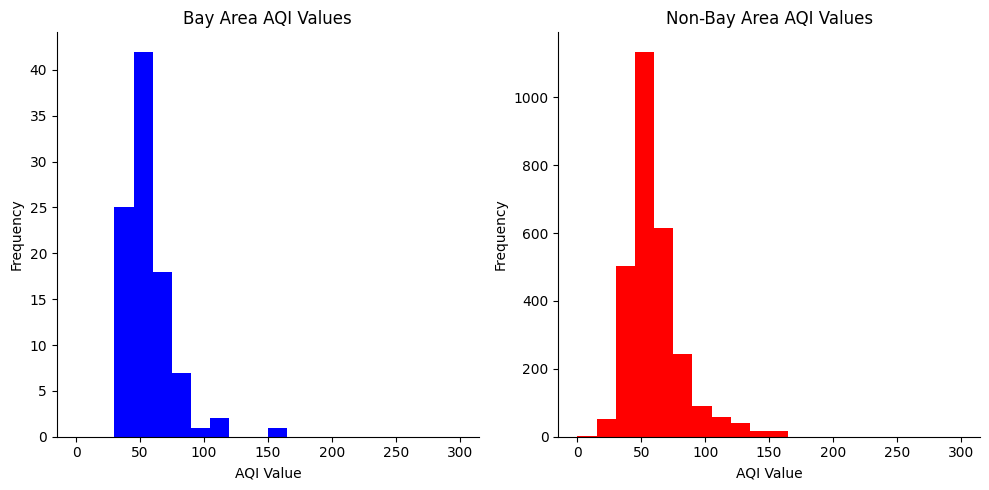

In [ ]:
# Plot AQI Values for bay area cities vs Non-bay area cities
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
aqi_bay_area_cities_df['AQI Value'].plot(
    kind='hist', bins=20, range=(0, 300), ax=axes[0], color='blue', title='Bay Area AQI Values'
)
axes[0].spines[['top', 'right']].set_visible(False)

aqi_non_bay_area_cities_df['AQI Value'].plot(
    kind='hist', bins=20, range=(0, 300), ax=axes[1], color='red', title='Non-Bay Area AQI Values'
)
axes[1].spines[['top', 'right']].set_visible(False)

for ax in axes:
    ax.set_xlabel('AQI Value')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

*   The Comparison of Bay area AQI vs non Bay Area AQI shows us that AQI values are mostly similar with slightly higher AQI for non Bay Area Cities.

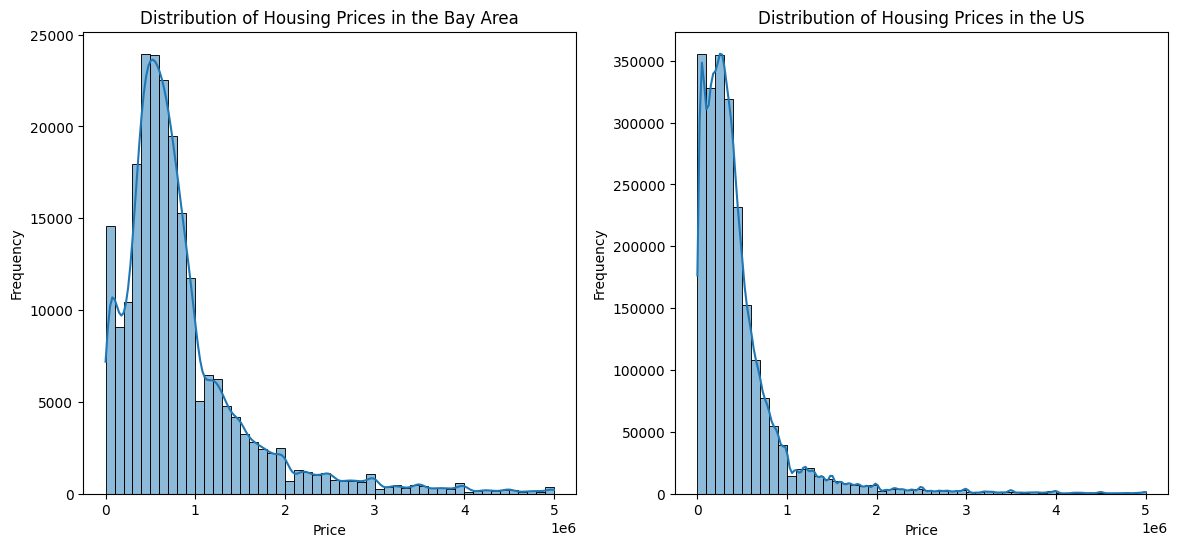

In [ ]:
# Find the California housing under 5 million dollars
ca_under_5mil = california_df[california_df['price']<= 5000000]
rest_us = realtor_df[(realtor_df['state'] != 'California') & (realtor_df['zip_code'].isin(combined_zipcodes)==False)]
us_under_5mil = rest_us[rest_us['price']<= 5000000]

# Plot the Distribution of Housing Prices in the Bay Area vs US
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.histplot(ca_under_5mil['price'], kde=True, bins=50, ax=axes[0])
axes[0].set_title('Distribution of Housing Prices in the Bay Area')
axes[0].set_xlabel('Price')
axes[0].set_ylabel('Frequency')

sns.histplot(us_under_5mil['price'], kde=True, bins=50, ax=axes[1])
axes[1].set_title('Distribution of Housing Prices in the US')
axes[1].set_xlabel('Price')
axes[1].set_ylabel('Frequency')

plt.show()

*   Distribution of housing costs in the Bay Area vs. the rest of the US.

### Cost of Living EDA



*   Explore the cost of living dataset and each of the features in this dataset


In [ ]:
# For each state, average the food cost
states = cost_of_living_us_df['state'].unique()
avg_food_cost_df = cost_of_living_us_df.groupby('state')['food_cost'].mean()
avg_food_cost_df = avg_food_cost_df.sort_index()

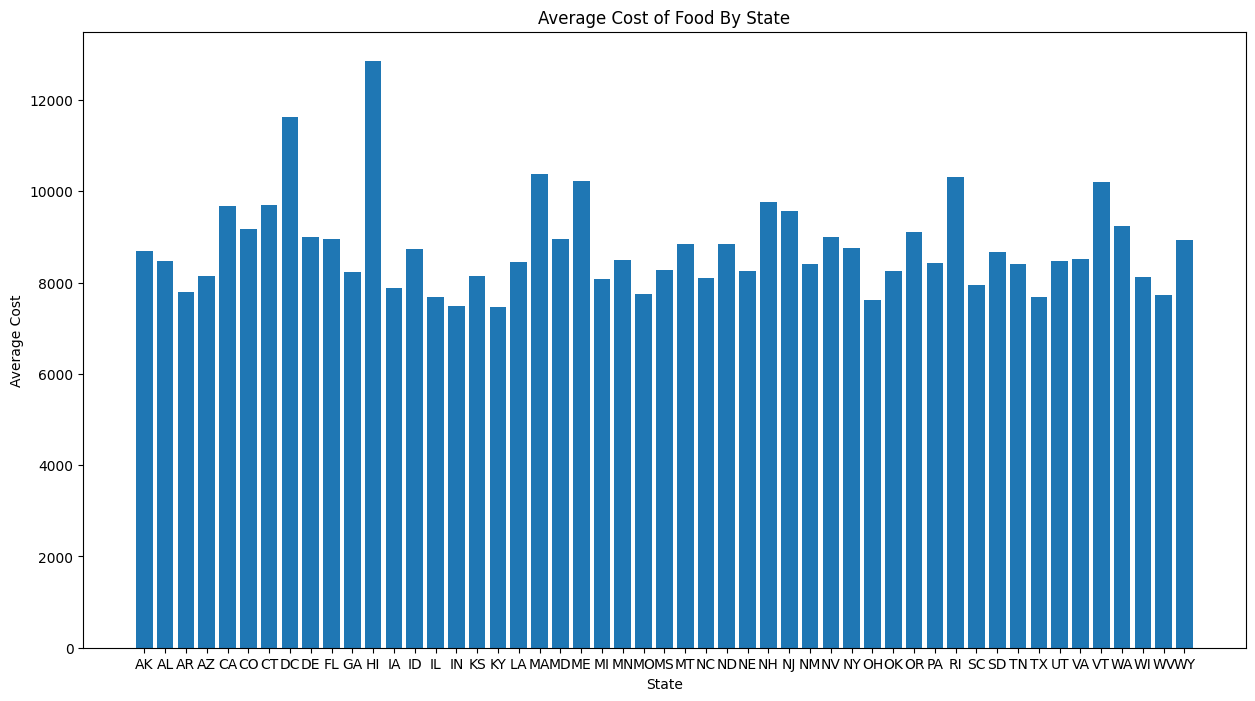

In [ ]:
# Plot average cost of food of each state
plt.figure(figsize=(15,8))
plt.bar(avg_food_cost_df.index, avg_food_cost_df.values.astype(float))
plt.title("Average Cost of Food By State")
plt.xlabel("State")
plt.ylabel("Average Cost")
plt.show()

In [ ]:
avg_food_cost_df = avg_food_cost_df.sort_values(ascending=False)
avg_food_cost_df.head(10)

state
HI    12852.929726
DC    11631.158784
MA    10370.573459
RI    10320.303487
ME    10236.024646
VT    10203.646728
NH     9769.636487
CT     9703.825338
CA     9673.952906
NJ     9574.312942
Name: food_cost, dtype: float64

*   California is rank 9 in terms of average food cost with Hawaii being the highest

In [ ]:
# For each state, average the transportation cost
states = cost_of_living_us_df['state'].unique()
avg_transportation_cost = cost_of_living_us_df.groupby('state')['transportation_cost'].mean()
avg_transportation_cost = avg_transportation_cost.sort_index()

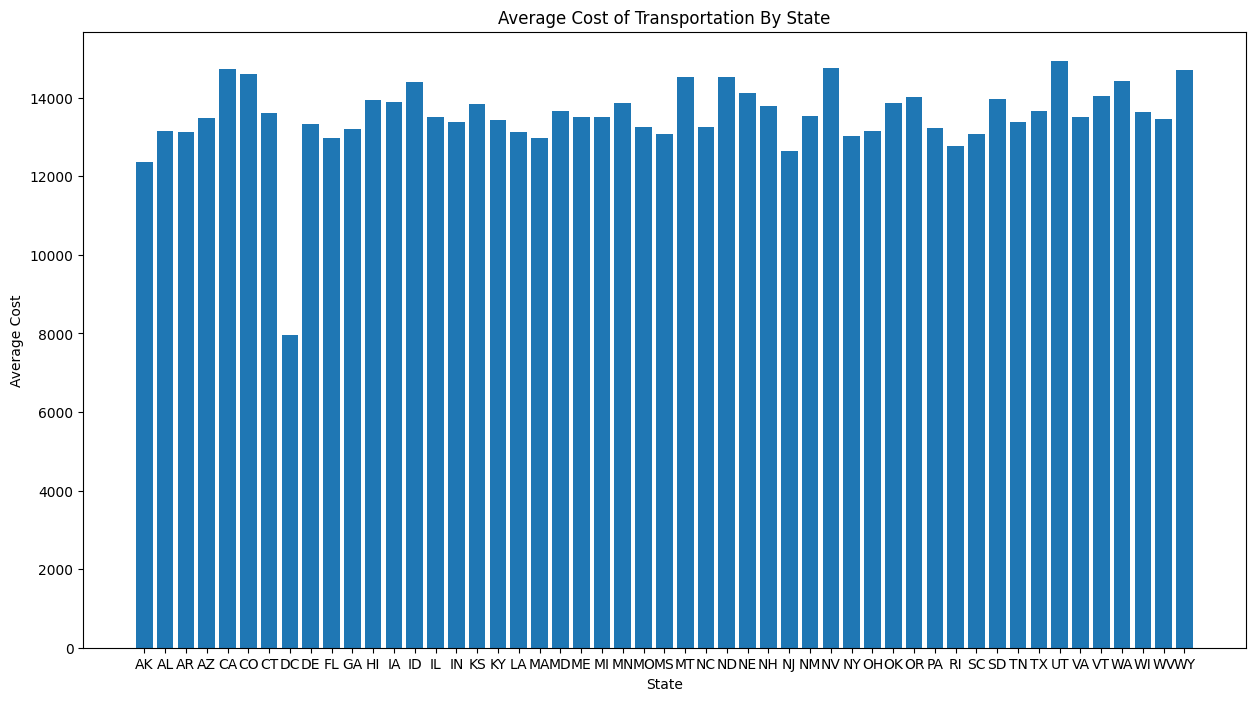

In [ ]:
# Plot average cost of transportation of each state
plt.figure(figsize=(15,8))
plt.bar(avg_transportation_cost.index, avg_transportation_cost.values.astype(float))
plt.title("Average Cost of Transportation By State")
plt.xlabel("State")
plt.ylabel("Average Cost")
plt.show()

In [ ]:
avg_transportation_cost_sort = avg_transportation_cost.sort_values(ascending=False)
avg_transportation_cost_sort.head(10)

state
UT    14934.512679
NV    14758.563786
CA    14740.170922
WY    14694.428993
CO    14616.030773
MT    14527.148772
ND    14517.901461
WA    14428.061045
ID    14391.546486
NE    14130.400164
Name: transportation_cost, dtype: float64

*   California is ranked 3rd in terms of transportation with Utah being the highest average transportation cost

In [ ]:
# For each state, average the housing cost
states = cost_of_living_us_df['state'].unique()
avg_housing_cost = cost_of_living_us_df.groupby('state')['housing_cost'].mean()
avg_housing_cost = avg_housing_cost.sort_index()

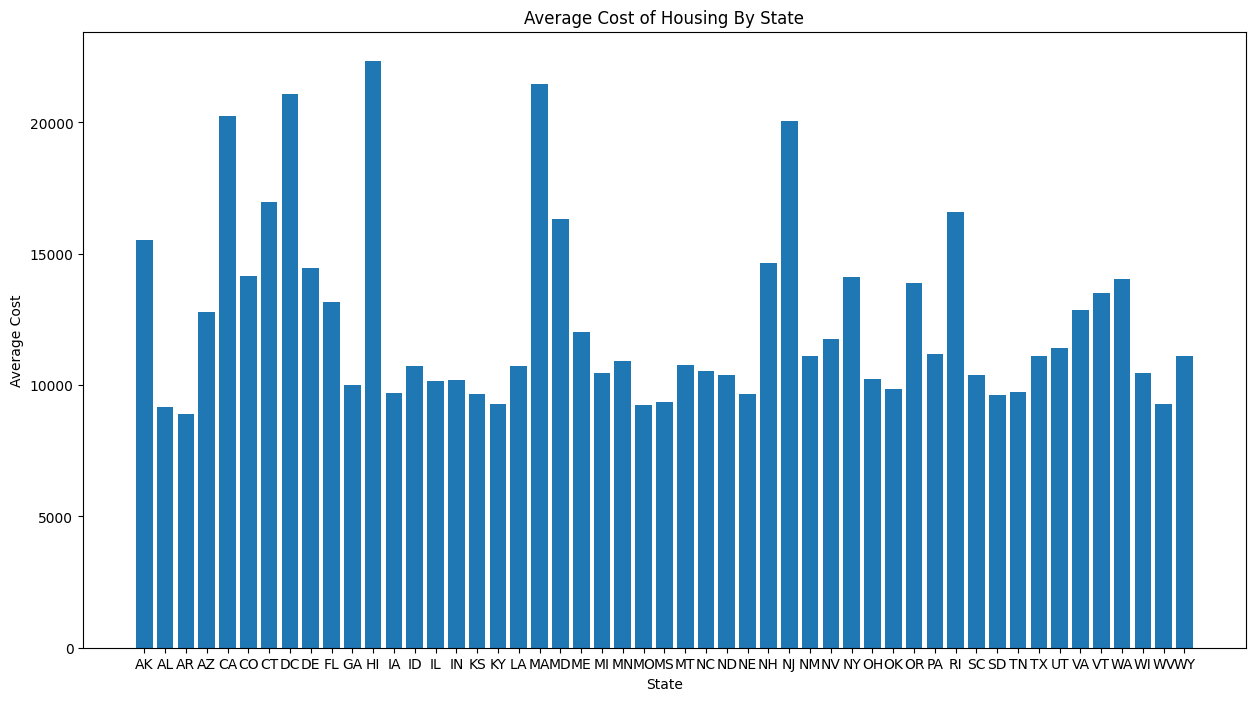

In [ ]:
plt.figure(figsize=(15,8))
plt.bar(avg_housing_cost.index, avg_housing_cost.values.astype(float))
plt.title("Average Cost of Housing By State")
plt.xlabel("State")
plt.ylabel("Average Cost")
plt.show()

In [ ]:
avg_housing_cost_sort = avg_housing_cost.sort_values(ascending=False)
avg_housing_cost_sort.head(10)

state
HI    22335.139128
MA    21447.662337
DC    21089.385960
CA    20232.487360
NJ    20041.624334
CT    16953.564421
RI    16594.725254
MD    16307.275198
AK    15520.427586
NH    14636.287375
Name: housing_cost, dtype: float64

*   California is ranked 4th in terms of housing cost with Hawaii having the highest

In [ ]:
# For each state, average the healthcare cost
states = cost_of_living_us_df['state'].unique()
avg_healthcare_cost = cost_of_living_us_df.groupby('state')['healthcare_cost'].mean()
avg_healthcare_cost = avg_healthcare_cost.sort_index()

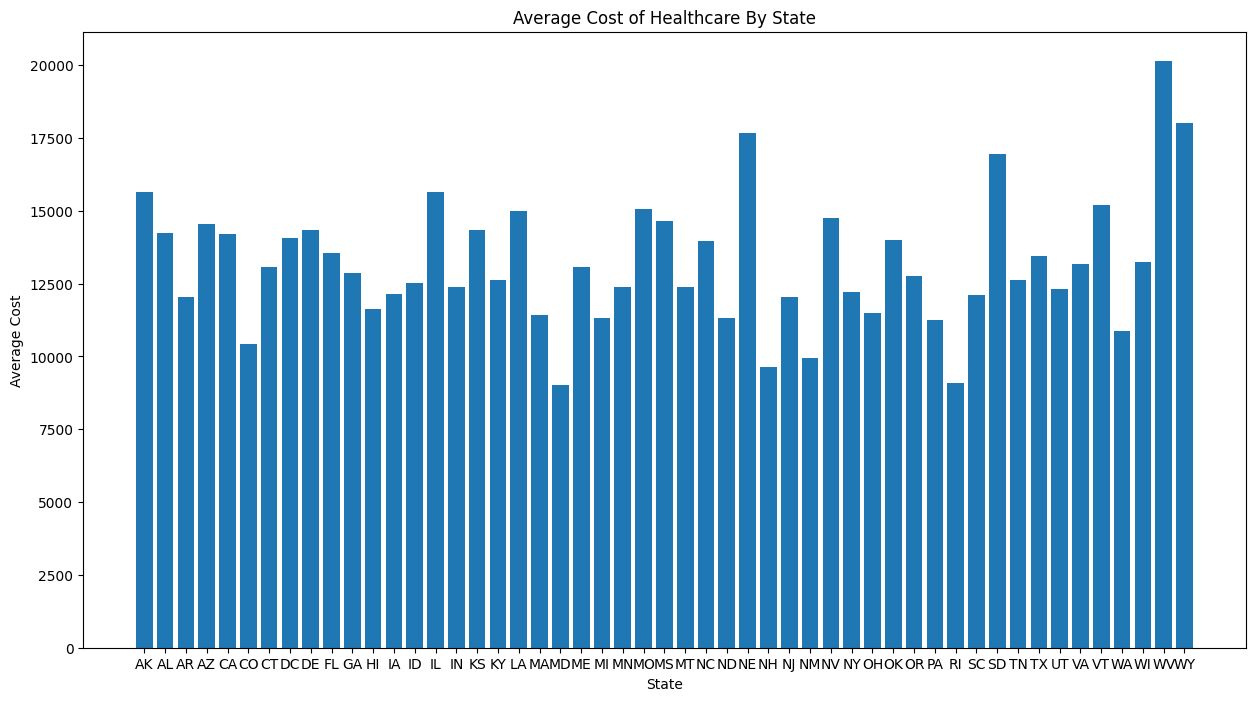

In [ ]:
plt.figure(figsize=(15,8))
plt.bar(avg_healthcare_cost.index, avg_healthcare_cost.values.astype(float))
plt.title("Average Cost of Healthcare By State")
plt.xlabel("State")
plt.ylabel("Average Cost")
plt.show()

In [ ]:
avg_healthcare_cost_sort = avg_healthcare_cost.sort_values(ascending=False)
avg_healthcare_cost_sort.head(10)

state
WV    20142.651212
WY    18008.334870
NE    17667.028343
SD    16936.346935
AK    15641.815574
IL    15632.785639
VT    15202.040325
MO    15048.010371
LA    14997.659179
NV    14747.497513
Name: healthcare_cost, dtype: float64

*   California is not on the top list in terms of average healthcare cost

In [ ]:
# For each state, average the childcare cost
states = cost_of_living_us_df['state'].unique()
avg_childcare_cost = cost_of_living_us_df.groupby('state')['childcare_cost'].mean()
avg_childcare_cost = avg_childcare_cost.sort_index()

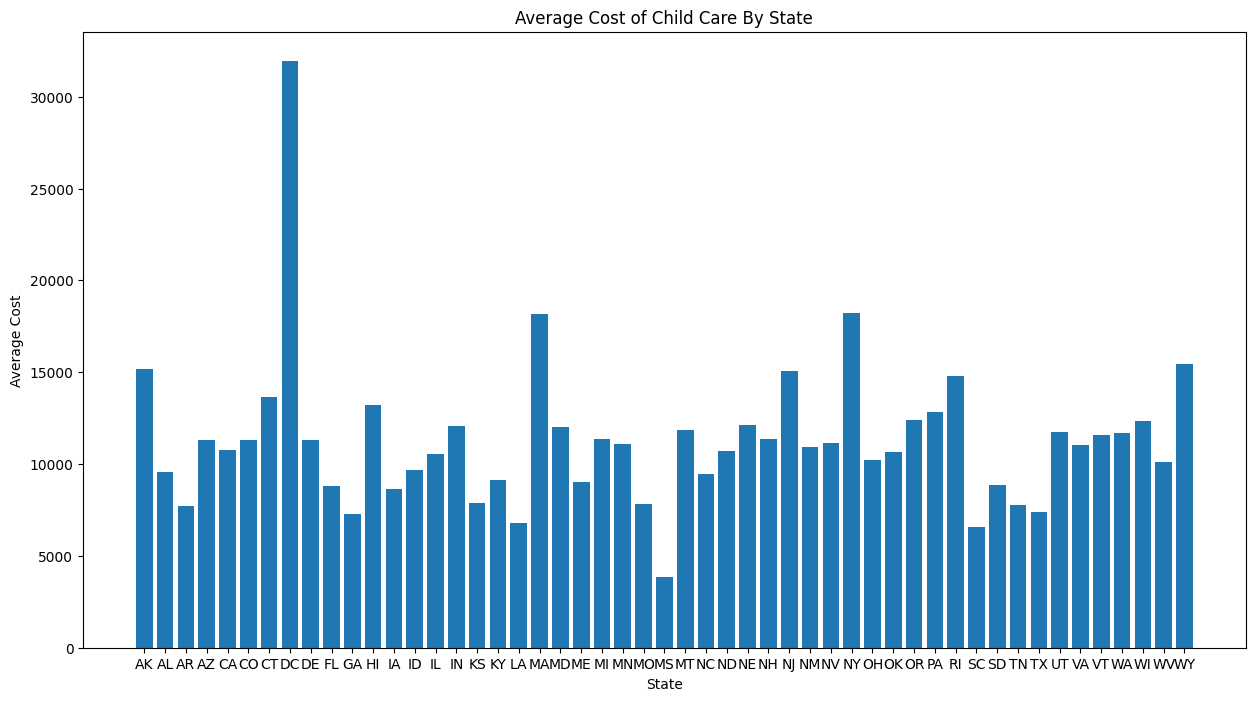

In [ ]:
plt.figure(figsize=(15,8))
plt.bar(avg_childcare_cost.index, avg_childcare_cost.values.astype(float))
plt.title("Average Cost of Child Care By State")
plt.xlabel("State")
plt.ylabel("Average Cost")
plt.show()

In [ ]:
avg_childcare_cost_sort = avg_childcare_cost.sort_values(ascending=False)
avg_childcare_cost_sort.head(10)

state
DC    31940.492400
NY    18234.229635
MA    18146.393779
WY    15455.258306
AK    15194.391719
NJ    15062.561234
RI    14802.695184
CT    13624.394466
HI    13198.917811
PA    12808.142150
Name: childcare_cost, dtype: float64

*   California is not on the top average child care cost

In [ ]:
# For each state, average the necessities cost
states = cost_of_living_us_df['state'].unique()
avg_other_necessities_cost = cost_of_living_us_df.groupby('state')['other_necessities_cost'].mean()
avg_other_necessities_cost = avg_other_necessities_cost.sort_index()

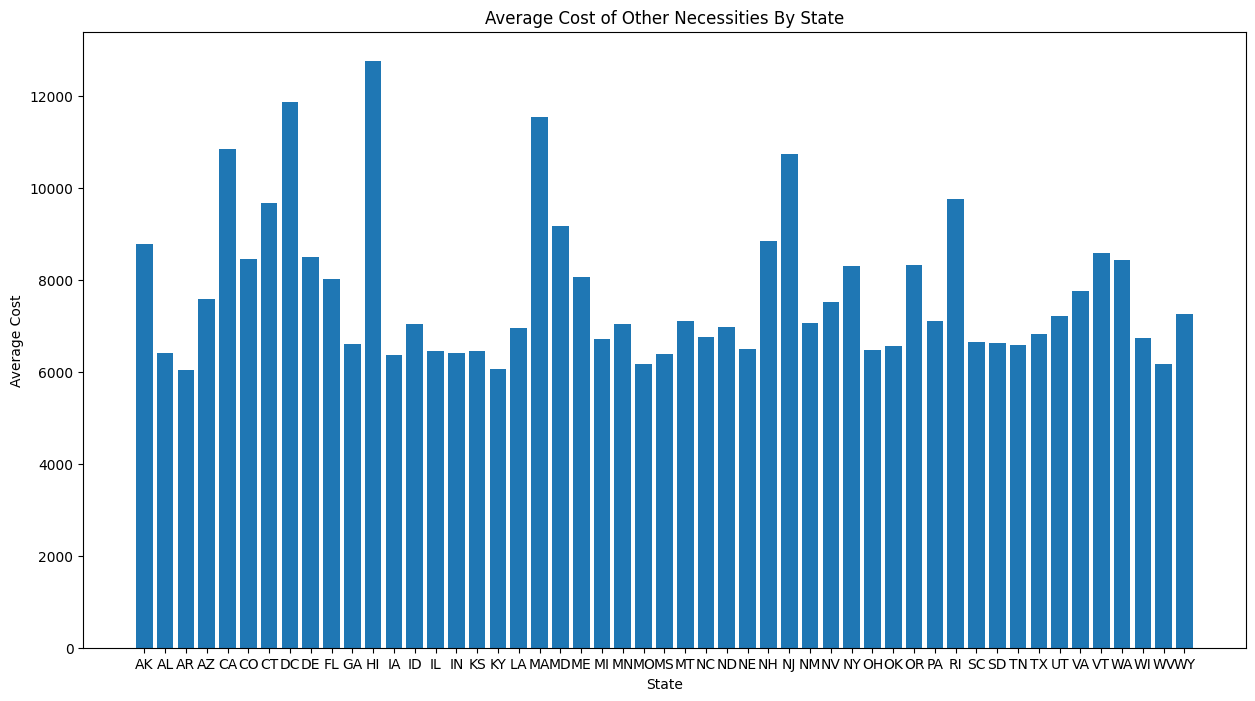

In [ ]:
plt.figure(figsize=(15,8))
plt.bar(avg_other_necessities_cost.index, avg_other_necessities_cost.values.astype(float))
plt.title("Average Cost of Other Necessities By State")
plt.xlabel("State")
plt.ylabel("Average Cost")
plt.show()

In [ ]:
avg_other_necessities_cost_sort = avg_other_necessities_cost.sort_values(ascending=False)
avg_other_necessities_cost_sort.head(10)

state
HI    12750.024823
DC    11855.943468
MA    11529.001648
CA    10836.282740
NJ    10731.022045
RI     9752.376358
CT     9659.023610
MD     9155.159809
NH     8843.228728
AK     8774.125398
Name: other_necessities_cost, dtype: float64

*   California is ranked the 4th in terms of average necessities cost and Hawaii has the highest

In [ ]:
# For each state, average the total cost
states = cost_of_living_us_df['state'].unique()
avg_total_cost = cost_of_living_us_df.groupby('state')['total_cost'].mean()
avg_total_cost = avg_total_cost.sort_index()

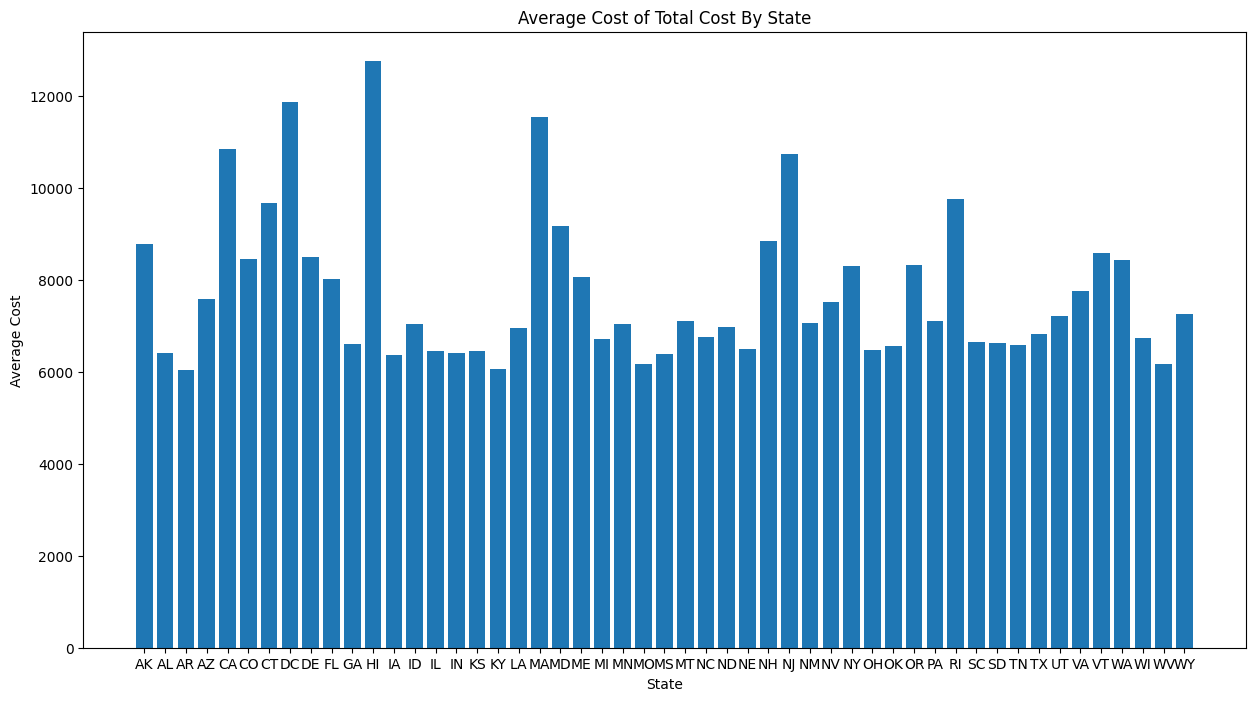

In [ ]:
plt.figure(figsize=(15,8))
plt.bar(avg_other_necessities_cost.index, avg_other_necessities_cost.values.astype(float))
plt.title("Average Cost of Total Cost By State")
plt.xlabel("State")
plt.ylabel("Average Cost")
plt.show()

In [ ]:
avg_total_cost_sort = avg_total_cost.sort_values(ascending=False)
avg_total_cost_sort.head(10)

state
DC    120289.636920
HI    104897.262264
MA    101891.575946
CA     93179.163060
NJ     92575.263891
CT     90013.504620
NY     86764.054353
AK     85234.557360
WY     84289.773668
OR     83818.032683
Name: total_cost, dtype: float64

*   California is ranked the 4th in terms of total cost and DC has the highest

In [ ]:
# For each state, average the median family income cost
states = cost_of_living_us_df['state'].unique()
avg_median_family_income = cost_of_living_us_df.groupby('state')['median_family_income'].mean()
avg_median_family_income = avg_median_family_income.sort_index()

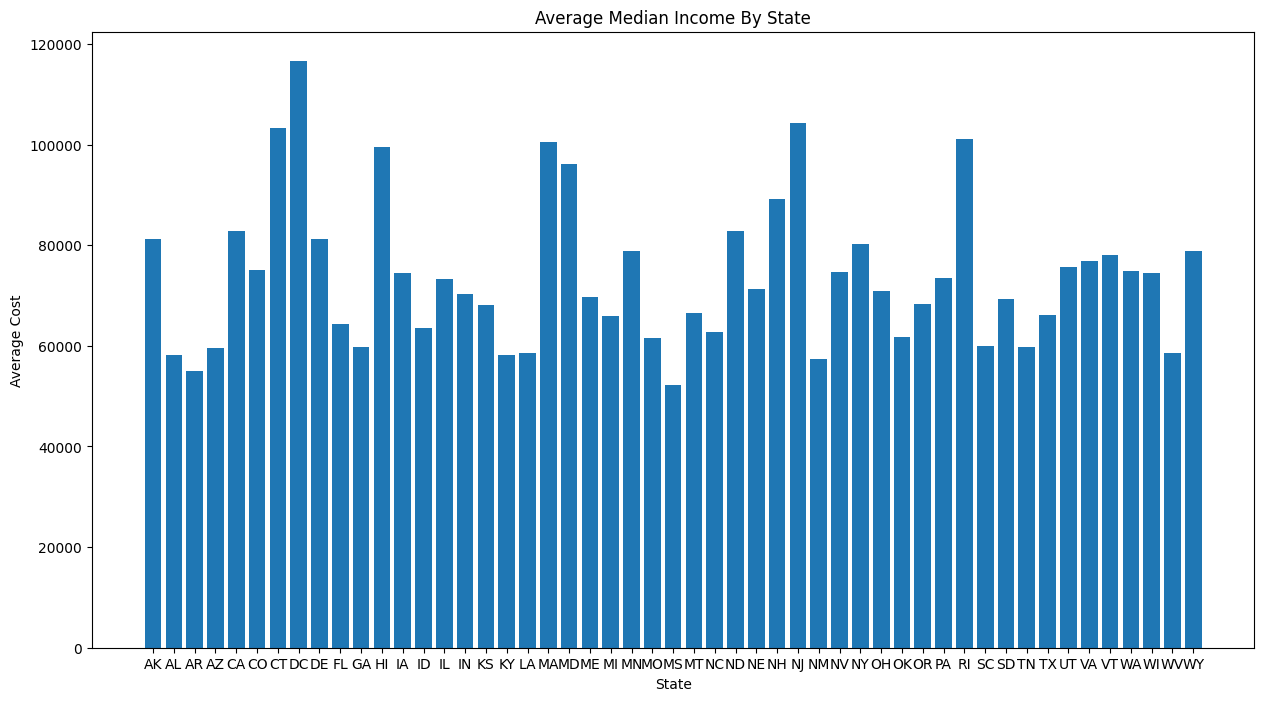

In [ ]:
plt.figure(figsize=(15,8))
plt.bar(avg_median_family_income.index, avg_median_family_income.values.astype(float))
plt.title("Average Median Income By State")
plt.xlabel("State")
plt.ylabel("Average Cost")
plt.show()

In [ ]:
avg_median_family_income_sort = avg_median_family_income.sort_values(ascending=False)
avg_median_family_income_sort.head(10)

state
DC    116607.390625
NJ    104246.459821
CT    103228.233398
RI    101153.248438
MA    100532.209821
HI     99596.992188
MD     96138.127604
NH     89199.250000
CA     82922.169248
ND     82881.291421
Name: median_family_income, dtype: float64

*   California is ranked the 9th in terms of average median family income where DC is the highest

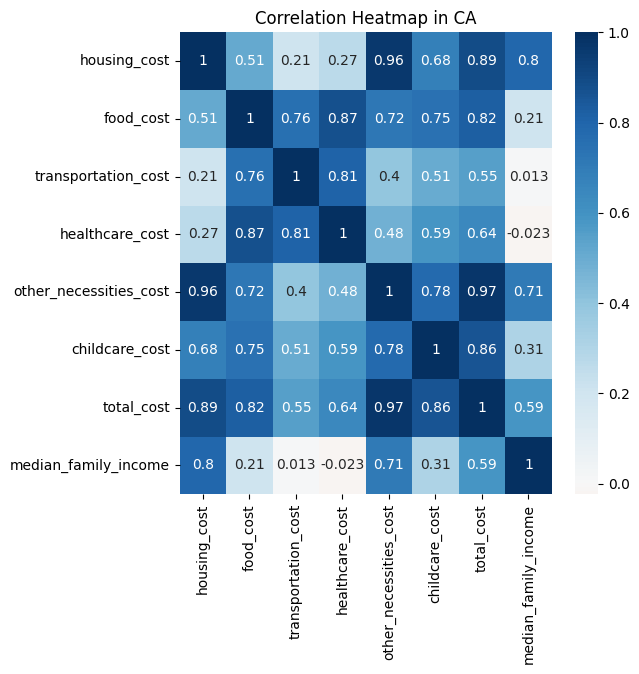

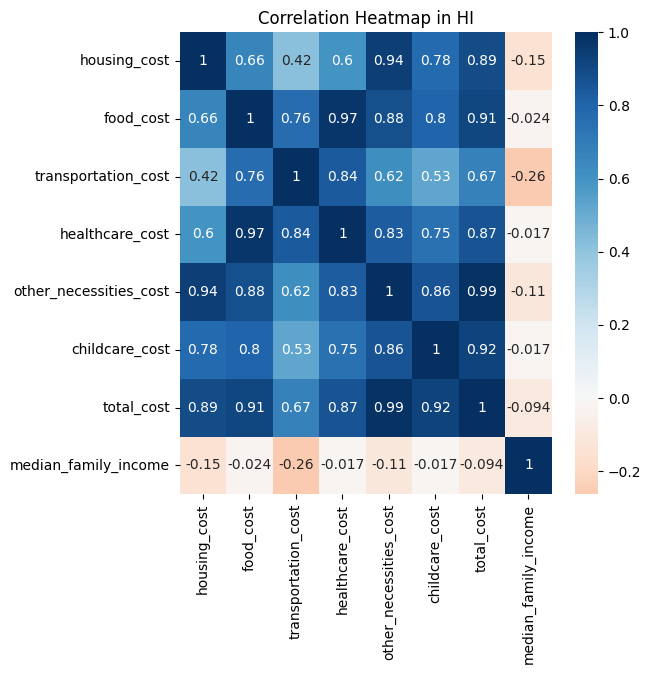

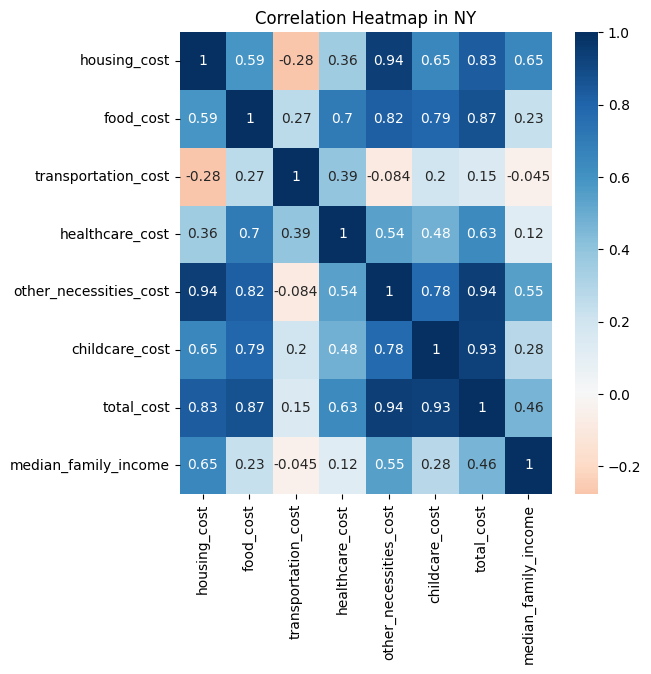

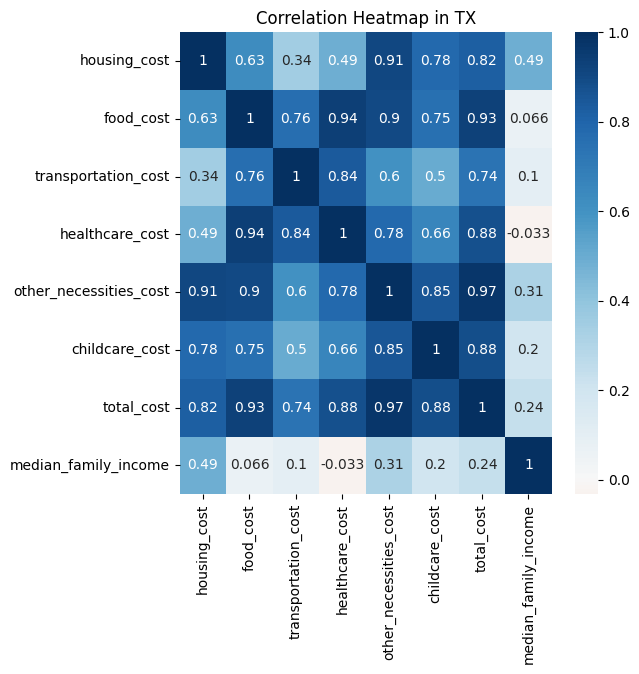

In [ ]:
# Create a heat map between the different costs for a few states in comparison with CA
cost_df = cost_of_living_us_df[['housing_cost', 'food_cost', 'transportation_cost', 'healthcare_cost', 'other_necessities_cost', 'childcare_cost', 'total_cost', 'median_family_income']]

states = cost_of_living_us_df['state'].unique()
state_corrs = {}

for state in states:
  state_info = cost_df[cost_of_living_us_df['state'] == state]
  state_corrs[state] = state_info.corr()

for state in ['CA', 'HI', 'NY', 'TX']:
  plt.figure(figsize=(6,6))
  sns.heatmap(state_corrs[state], annot=True, cmap='RdBu', center=0)
  plt.title(f"Correlation Heatmap in {state}")
  plt.show()


*   According the to heatmap, housing cost plays a big role in the total cost in CA. Similar behavior can be seem in other states as well especially Hawaii and New York.

* Other necessity cost and median family  income also has a high correlation with housing cost

### Salaries in San Francisco EDA

In [ ]:
  salaries_sf_df.head()
  # Find the top paying jobs
  top_paying_jobs = salaries_sf_df.groupby('JobTitle')['TotalPay'].mean().sort_values(ascending=False)
  top_paying_jobs.head(10)

JobTitle
GENERAL MANAGER-METROPOLITAN TRANSIT AUTHORITY    399211.275000
Chief Investment Officer                          339653.700000
Chief of Police                                   329183.646667
Chief, Fire Department                            325971.683333
DEPUTY DIRECTOR OF INVESTMENTS                    307899.460000
CHIEF OF DEPARTMENT, (FIRE DEPARTMENT)            302377.730000
Gen Mgr, Public Trnsp Dept                        297769.413333
Asst Chf of Dept (Fire Dept)                      281763.483889
DEPUTY CHIEF OF DEPARTMENT,(FIRE DEPARTMENT)      279359.560000
Dep Dir for Investments, Ret                      278592.545000
Name: TotalPay, dtype: float64



*   Top paying salary in San Francisco based on this dataset are General Manager in MTA, Chief Investment Officer, and Chief of Police



### Median Family Income vs. Housing Price (Combined datasets)

In [ ]:
# Add county column to the realtor dataset to merge with cost of living dataset
realtor_county = realtor_df.merge(cities_to_county_df, on='city', how='inner')
realtor_county = realtor_county.drop_duplicates()
realtor_county = realtor_county.rename(columns={'county_name': 'county'})
realtor_county.head()

brokered_by    status     price  bed  bath  acre_lot     street      city  \
0     103378.0  for_sale  105000.0  3.0   2.0      0.12  1962661.0  Adjuntas   
1      52707.0  for_sale   80000.0  4.0   2.0      0.08  1902874.0  Adjuntas   
2      31239.0  for_sale  145000.0  4.0   2.0      0.10  1947675.0     Ponce   
3       1205.0  for_sale   50000.0  3.0   1.0      0.20  1298094.0    Ciales   
4      50739.0  for_sale   71600.0  3.0   2.0      0.08  1048466.0     Ponce   

  state  zip_code  house_size prev_sold_date    county  
0    PR     601.0       920.0            NaN  Adjuntas  
1    PR     601.0      1527.0            NaN  Adjuntas  
2    PR     731.0      1800.0            NaN     Ponce  
3    PR     639.0      2040.0            NaN    Ciales  
4    PR     731.0      1050.0            NaN     Ponce

In [ ]:
# Merge realtor and cost of living dataset
realtor_county['county'] = realtor_county['county'].str.replace(' County', '', regex=False).str.lower()
cost_of_living_us_df['county'] = cost_of_living_us_df['county'].str.replace(' County', '', regex=False).str.lower()

# Filter the realtor price by cities with only the following columns: price, city, state, and county
realtor_price_by_cites_df = realtor_county[['price', 'city','state', 'county']]

# Filter the cost of living by cities with only the following columns: state, median family income, and county
cost_of_living_per_cities_df = cost_of_living_us_df[['state', 'median_family_income', 'county']]

print(realtor_price_by_cites_df.head())
print(cost_of_living_per_cities_df.head())

      price      city state    county
0  105000.0  Adjuntas    PR  adjuntas
1   80000.0  Adjuntas    PR  adjuntas
2  145000.0     Ponce    PR     ponce
3   50000.0    Ciales    PR    ciales
4   71600.0     Ponce    PR     ponce
  state  median_family_income   county
0    AL          73010.414062  autauga
1    AL          73010.414062  autauga
2    AL          73010.414062  autauga
3    AL          73010.414062  autauga
4    AL          73010.414062  autauga


In [ ]:
# Finish cost of living merge dataset
cost_of_living_merge = realtor_price_by_cites_df.merge(cost_of_living_per_cities_df, on=['county', 'state'], how='inner')
cost_of_living_merge = cost_of_living_merge.drop_duplicates().dropna().reset_index(drop=True)
# print(cost_of_living_merge.shape[0])
cost_of_living_merge.head()

price         city state     county  median_family_income
0  105000.0  Northampton    MA  hampshire           98470.56250
1  184900.0  Springfield    MA    hampden           74012.59375
2  249900.0     Chicopee    MA    hampden           74012.59375
3  240000.0     Chicopee    MA    hampden           74012.59375
4  279900.0  Springfield    MA    hampden           74012.59375

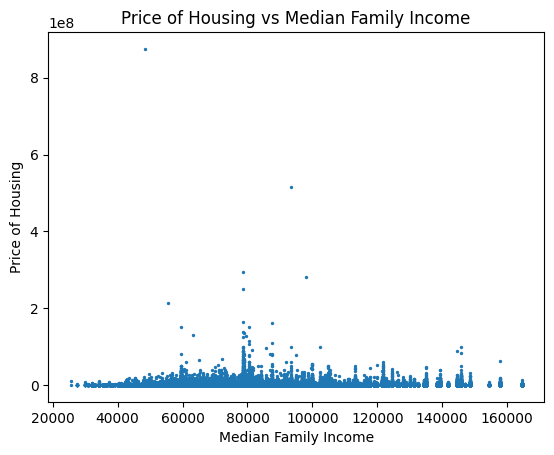

In [ ]:
# Plot the Price of housing with median family income
plt.scatter(cost_of_living_merge['median_family_income'], cost_of_living_merge['price'], s=2)
plt.title('Price of Housing vs Median Family Income')
plt.xlabel('Median Family Income')
plt.ylabel('Price of Housing')
plt.show()



*   Used a scatter plot, there seems to have some outlier in the dataset and not a strong correlation



### Proposition 21 voter data and SF precinct EDA (Combined datasets)

In [ ]:
# Merge prop21 and sf_precinct datasets
merged_df = sf_precincts.merge(prop21, left_on='prec_2012', right_on='Precinct')
merged_df['geometry'] = merged_df['the_geom'].apply(lambda x: loads(x))
merged_df.head(3)

prec_2012                                           the_geom      neighrep  \
0      9151  MULTIPOLYGON (((-122.44730200045501 37.7823919...  LRL HTS/ANZA   
1      9134  MULTIPOLYGON (((-122.4500920005295 37.78211700...  LRL HTS/ANZA   
2      9152  MULTIPOLYGON (((-122.45300300019134 37.7749710...  LRL HTS/ANZA   

  Precinct  Yes    Yes%   No     No% Total Votes  \
0     9151  345  0.4978  348  0.5022         693   
1     9134  415  0.5220  380  0.4780         795   
2     9152  215  0.6143  135  0.3857         350   

                                            geometry  
0  MULTIPOLYGON (((-122.44730200045501 37.7823919...  
1  MULTIPOLYGON (((-122.4500920005295 37.78211700...  
2  MULTIPOLYGON (((-122.45300300019134 37.7749710...

In [ ]:
# Coordinates for San Francisco
sf_lat, sf_lon = 37.7749, -122.4194
m = folium.Map(location=[sf_lat, sf_lon], zoom_start=12)

colormap = linear.YlOrRd_09.scale(min(merged_df['Yes%']), max(merged_df['Yes%']))
heat_data = []
for idx, row in merged_df.iterrows():
    yes_per = row['Yes%']
    color = colormap(yes_per)
    if isinstance(row['geometry'], MultiPolygon):
          for geom in row['geometry'].geoms:
            folium.GeoJson(
                geom.__geo_interface__,
                style_function=lambda x, color=color: {
                    'fillColor': color,
                    'fillOpacity': 0.5,
                    'color': 'black',
                    'weight': 1
                }
            ).add_to(m)
            for x, y in geom.exterior.coords:
              heat_data.append([x, y, yes_per])

HeatMap(heat_data, min_opacity=0.2, max_val=100, gradient={0.0: 'yellow', 0.5: 'orange', 1.0: 'red'}).add_to(m)
colormap.add_to(m)
m

*   Heatmap of votes on Proposition 21 in 2020 aggregated by precinct. The darker the red, the more pro-rent control and against building more housing the votes were.

### California Housing Data EDA
Note: this data is from more than 20 years ago, so the distribution may be very different.

In [ ]:
ca_housing['median_house_value_adjusted'] = ca_housing['median_house_value'].apply(lambda x: x*1.71)

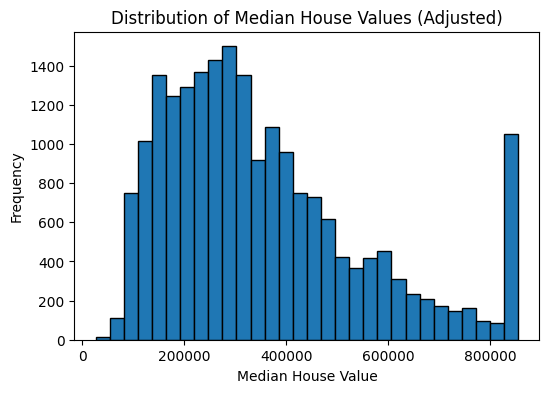

In [ ]:
# Plot the distribution of median housing values
plt.figure(figsize=(6, 4))
plt.hist(ca_housing['median_house_value_adjusted'], bins=30, edgecolor='black')
plt.title('Distribution of Median House Values (Adjusted)')
plt.xlabel('Median House Value')
plt.ylabel('Frequency')
plt.show()



*   There seem to be a general downward trend as the median housing price increase the frequency decrease except after the median housing price hits above 800000



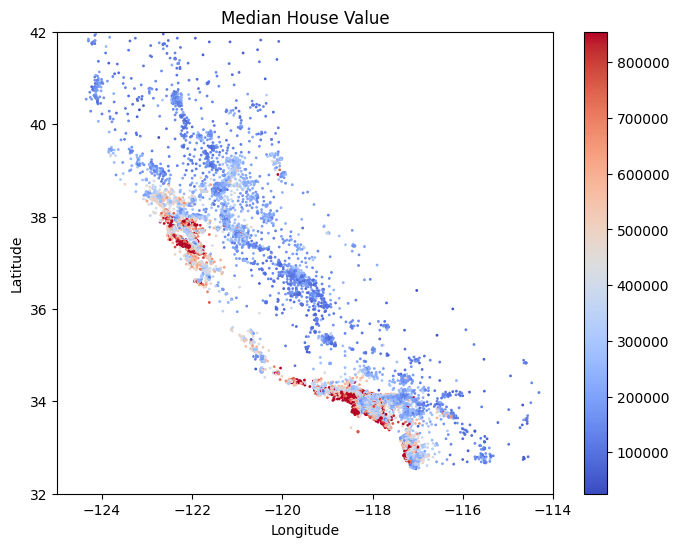

In [ ]:
# Plot the median house value
plt.figure(figsize=[8,6])
plt.ylim(32,42)
plt.xlim(-125,-114)
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.title("Median House Value")
plt.scatter(x = ca_housing["longitude"],
            y = ca_housing["latitude"],
            c = ca_housing["median_house_value_adjusted"],
            cmap="coolwarm",
            s=1)
plt.colorbar()
plt.show()



*   The trend is closer to the Bay the higher the housing price which match our expectation



In [ ]:
# Created a heat map based on the median housing value
m = folium.Map(location=[sf_lat, sf_lon], zoom_start=9)

max_value = ca_housing['median_house_value_adjusted'].max()
heat_data = [
    [row['latitude'], row['longitude'], row['median_house_value_adjusted'] / max_value]
    for idx, row in ca_housing.iterrows()
]

HeatMap(heat_data, radius=10, blur=6, max_zoom=1).add_to(m)
colormap = cm.LinearColormap(
    colors=['blue', 'yellow', 'red'],
    vmin=ca_housing['median_house_value_adjusted'].min(),
    vmax=ca_housing['median_house_value_adjusted'].max(),
    caption='Median House Value'
)
colormap.add_to(m)
m



*   Similar trend, closer to Bay Area the higher the median housing price



### Tech companies EDA

### Zoning EDA

In [ ]:
# Group zoning by acreage sum
zoning.groupby('zoning_type')['acreage'].sum().sort_values(ascending=False).head()

zoning_type
Residential            1.000484e+06
Agricultural           1.946853e+04
Planned Development    5.557883e+03
Other                  2.430336e+03
Commercial             1.361983e+03
Name: acreage, dtype: float64

In [ ]:
residential = zoning[zoning['zoning_type']=='Residential']

In [ ]:
# Get number of single family residential zoning areas
residential['single_family'] = residential['zoning'].apply(lambda x: 1 if 'R-1' in x else 0)
residential.groupby('single_family')['zoning'].count()

<ipython-input-222-cddfa2cee707>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



single_family
0    5552
1    2079
Name: zoning, dtype: int64

In [ ]:
# Get number of residential areas that have affordable housing programs
residential['affordability'] = residential['affordability'].fillna(0)
residential['affordability'] = residential['affordability'].apply(lambda x: 1 if x != 0 else x)
residential.groupby('affordability')['zoning'].count()

<ipython-input-223-b5fee327322b>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-223-b5fee327322b>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



affordability
0    6880
1     751
Name: zoning, dtype: int64

### Cost of living & real estate/housing EDA (Combined datasets)

In [ ]:
cost_of_living_ca_df = cost_of_living_ca_df.drop(columns=['case_id', 'areaname'])
cost_of_living_ca_df['county'] = cost_of_living_ca_df['county'].apply(lambda x: x.replace(' County', ''))
cost_of_living_ca_df.head()

state  isMetro   county family_member_count  housing_cost    food_cost  \
1860    CA        1  Alameda                1p0c    19058.5668   4118.92488   
1861    CA        1  Alameda                1p1c    28474.3356   6070.29456   
1862    CA        1  Alameda                1p2c    28474.3356   8893.99512   
1863    CA        1  Alameda                1p3c    38188.8276  11864.98164   
1864    CA        1  Alameda                1p4c    38188.8276  14523.54000   

      transportation_cost  healthcare_cost  other_necessities_cost  \
1860          10235.78688       5600.37996              8398.11912   
1861          11168.00904       8400.74712             12516.88200   
1862          12828.91560      11201.11380             13540.02000   
1863          13812.97440      14001.48000             18136.46880   
1864          14510.19240      16801.84680             19099.77000   

      childcare_cost        taxes   total_cost  median_family_income  
1860         0.00000  10417.30884   57829.0836          122820.71875  
1861     11404.00416  15716.00880   93750.2808          122820.71875  
1862     17473.90560  19304.46840  111716.7540          122820.71875  
1863     19341.57000  26596.63200  141942.9360          122820.71875  
1864     19341.57000  27321.17280  149786.9160          122820.71875

In [ ]:
# Cost of living – aggregate by county
col_ca_by_county_df = cost_of_living_ca_df.drop(columns=['family_member_count','state']).groupby('county').mean()
col_ca_by_county_df=col_ca_by_county_df.reset_index()
col_ca_by_county_df.head()

county  isMetro  housing_cost     food_cost  transportation_cost  \
0    Alameda      1.0   30882.04788  10664.134632         13677.410592   
1     Alpine      0.0   14311.20000   9912.004908         17413.645320   
2     Amador      0.0   15525.60000  11281.955172         16344.244680   
3      Butte      1.0   15918.00000   9052.426344         13989.207264   
4  Calaveras      0.0   14245.20000  11926.638648         16531.370160   

   healthcare_cost  other_necessities_cost  childcare_cost         taxes  \
0     14001.303612            15053.820576    13512.209952  19888.090716   
1     15874.842312             8777.022288     9068.572944  10420.476744   
2     13929.724512             9713.434524     9411.342960  10799.940936   
3     15647.172720             9047.770320     9991.455144   9810.569940   
4     15874.842312             9483.089412     9143.588088  11213.870292   

     total_cost  median_family_income  
0  117679.01916         122820.718750  
1   85777.76412          97334.890625  
2   87006.24396          79965.101562  
3   83456.60160          69683.492188  
4   88418.59920          83174.960938

In [ ]:
# Merging cities_to_county_df to add county column to real estate data, since cost of living df only has data aggregated by county
ca_real_estate = california_df.merge(cities_to_county_df, left_on='city', right_on='city')
ca_real_estate.head()

brokered_by    status      price  bed  bath  acre_lot     street  \
0      17458.0  for_sale   199000.0  NaN   NaN      5.10     2937.0   
1      17458.0  for_sale  2595000.0  NaN   NaN    901.00  1983508.0   
2       4311.0  for_sale   199900.0  3.0   1.0      0.18  1466188.0   
3       4311.0  for_sale   172999.0  3.0   2.0      0.16   987585.0   
4      64877.0  for_sale    79900.0  4.0   2.0      0.16  1533451.0   

          city       state  zip_code  house_size prev_sold_date county_name  
0      Milford  California   96121.0         NaN            NaN      Sussex  
1  Amador City  California   95651.0         NaN            NaN      Amador  
2       Blythe  California   92225.0      1014.0            NaN   Riverside  
3       Blythe  California   92225.0      1132.0     1984-06-29   Riverside  
4       Blythe  California   92225.0      1272.0            NaN   Riverside

In [ ]:
# Merge CA real estate with cost of living in that county
col_housing_merged = ca_real_estate.merge(col_ca_by_county_df, left_on='county_name', right_on='county')
col_housing_merged.head()

brokered_by    status      price  bed  bath  acre_lot     street  \
0      17458.0  for_sale  2595000.0  NaN   NaN    901.00  1983508.0   
1       4311.0  for_sale   199900.0  3.0   1.0      0.18  1466188.0   
2       4311.0  for_sale   172999.0  3.0   2.0      0.16   987585.0   
3      64877.0  for_sale    79900.0  4.0   2.0      0.16  1533451.0   
4      54422.0  for_sale    69000.0  3.0   1.0      0.91  1626662.0   

          city       state  zip_code  ...  isMetro  housing_cost  \
0  Amador City  California   95651.0  ...      0.0  15525.600000   
1       Blythe  California   92225.0  ...      1.0  18997.127784   
2       Blythe  California   92225.0  ...      1.0  18997.127784   
3       Blythe  California   92225.0  ...      1.0  18997.127784   
4       Blythe  California   92225.0  ...      1.0  18997.127784   

      food_cost transportation_cost  healthcare_cost  other_necessities_cost  \
0  11281.955172        16344.244680     13929.724512             9713.434524   
1   8461.467420        14187.011136     11158.440024             9949.332192   
2   8461.467420        14187.011136     11158.440024             9949.332192   
3   8461.467420        14187.011136     11158.440024             9949.332192   
4   8461.467420        14187.011136     11158.440024             9949.332192   

   childcare_cost         taxes   total_cost  median_family_income  
0     9411.342960  10799.940936  87006.24396          79965.101562  
1    10724.493768   9707.230248  83185.10280          79001.945312  
2    10724.493768   9707.230248  83185.10280          79001.945312  
3    10724.493768   9707.230248  83185.10280          79001.945312  
4    10724.493768   9707.230248  83185.10280          79001.945312  

[5 rows x 24 columns]

In [ ]:
# CA housing data aggregated by city
ca_housing_by_city = ca_housing.drop(columns='county_name')
ca_housing_by_city = ca_housing_by_city.groupby('city').agg({
    'housing_median_age': 'mean',
    'total_rooms':'sum',
    'total_bedrooms':'sum',
    'population':'sum',
    'households':'sum',
    'median_income':'mean',
    'median_house_value':'mean',
    'ocean_proximity':'mean'
})
ca_housing_by_city.reset_index(inplace=True)
ca_housing_by_city.head()

city  housing_median_age  total_rooms  total_bedrooms  population  \
0      Adelanto           11.333333      67976.0         13681.0     35210.0   
1  Agoura Hills           14.000000      86752.0         13567.0     35751.0   
2       Alameda           45.824561     233291.0         50954.0    135943.0   
3        Albany           45.818182      85411.0         17200.0     37886.0   
4      Alhambra           36.529412      92810.0         22042.0     61432.0   

   households  median_income  median_house_value  ocean_proximity  
0     11349.0       2.722953        98693.333333              4.0  
1     12354.0       6.185986       374943.000000              1.0  
2     48226.0       3.084980       170721.052632              2.0  
3     16519.0       4.154473       246395.454545              2.0  
4     21474.0       3.603012       244808.882353              3.0

In [ ]:
# Continue merging
col_housing_merged = col_housing_merged.merge(ca_housing_by_city, on='city')
col_housing_merged = col_housing_merged.merge(us_pollution_df, on='city')
col_housing_merged=col_housing_merged.drop(columns=['county_name','median_income', 'street','other_necessities_cost', 'total_cost'])
col_housing_merged.head()

brokered_by    status     price  bed  bath  acre_lot    city       state  \
0       4311.0  for_sale  199900.0  3.0   1.0      0.18  Blythe  California   
1       4311.0  for_sale  172999.0  3.0   2.0      0.16  Blythe  California   
2      64877.0  for_sale   79900.0  4.0   2.0      0.16  Blythe  California   
3      54422.0  for_sale   69000.0  3.0   1.0      0.91  Blythe  California   
4     109780.0  for_sale   75000.0  3.0   2.0      0.33  Blythe  California   

   zip_code  house_size  ... median_family_income housing_median_age  \
0   92225.0      1014.0  ...         79001.945312          21.052632   
1   92225.0      1132.0  ...         79001.945312          21.052632   
2   92225.0      1272.0  ...         79001.945312          21.052632   
3   92225.0      1134.0  ...         79001.945312          21.052632   
4   92225.0      1248.0  ...         79001.945312          21.052632   

   total_rooms  total_bedrooms  population  households  median_house_value  \
0      35562.0          8327.0     16694.0      5963.0        77747.368421   
1      35562.0          8327.0     16694.0      5963.0        77747.368421   
2      35562.0          8327.0     16694.0      5963.0        77747.368421   
3      35562.0          8327.0     16694.0      5963.0        77747.368421   
4      35562.0          8327.0     16694.0      5963.0        77747.368421   

   ocean_proximity  Country  AQI Value  
0              4.0       US         40  
1              4.0       US         40  
2              4.0       US         40  
3              4.0       US         40  
4              4.0       US         40  

[5 rows x 29 columns]

In [ ]:
# Renaming columns for clarity
col_housing_merged = col_housing_merged.rename({
    'housing_cost':'county_avg_housing_cost',
    'food_cost': "county_avg_food_cost",
    'transportation_cost': "county_avg_transport_cost",
    'healthcare_cost':'county_avg_heathcare_cost',
    'childcare_cost':'county_avg_childcare_cost',
    'taxes':'county_avg_taxes',
    'median_family_income': 'county_avg_family_income',
    'housing_median_age': 'city_avg_housing_age',
    'total_rooms':'total_rooms_in_city',
    'total_bedrooms':'total_bedrooms_in_city',
    'population':'city_population',
    'households': 'num_households_in_city',
    'median_house_value': 'city_avg_house_value',
    'ocean_proximity': 'city_ocean_proximity'
  }, axis=1)

In [ ]:
# Number of rows on the col_housing_merged dataset
col_housing_merged.shape[0]

127787

In [ ]:
# col_housing_merged.describe()
# Split the price into catorgories
percentiles = [0.2, 0.4, 0.6, 0.8, 1.0]
percentile_values = col_housing_merged['price'].quantile(percentiles)
print(percentile_values)

0.2       400000.0
0.4       575000.0
0.6       759000.0
0.8      1175000.0
1.0    295000000.0
Name: price, dtype: float64


In [ ]:
home_price_classes = {
    5: [1250001, 515000000], # luxury
    4: [799001, 1250000], # high end
    3:[599001,799000], # mid tier
    2:[415001, 599000], # low end
    1:[0, 415000] # very affordable
}

In [ ]:
# Get the price categories based on the price of the house
def get_price_class(price):
  for category, (low, high) in home_price_classes.items():
    if low <= price <= high:
      return category

col_housing_merged['price_class'] = col_housing_merged['price'].apply(get_price_class)
col_housing_merged.head()

brokered_by    status     price  bed  bath  acre_lot    city       state  \
0       4311.0  for_sale  199900.0  3.0   1.0      0.18  Blythe  California   
1       4311.0  for_sale  172999.0  3.0   2.0      0.16  Blythe  California   
2      64877.0  for_sale   79900.0  4.0   2.0      0.16  Blythe  California   
3      54422.0  for_sale   69000.0  3.0   1.0      0.91  Blythe  California   
4     109780.0  for_sale   75000.0  3.0   2.0      0.33  Blythe  California   

   zip_code  house_size  ... city_avg_housing_age total_rooms_in_city  \
0   92225.0      1014.0  ...            21.052632             35562.0   
1   92225.0      1132.0  ...            21.052632             35562.0   
2   92225.0      1272.0  ...            21.052632             35562.0   
3   92225.0      1134.0  ...            21.052632             35562.0   
4   92225.0      1248.0  ...            21.052632             35562.0   

   total_bedrooms_in_city  city_population  num_households_in_city  \
0                  8327.0          16694.0                  5963.0   
1                  8327.0          16694.0                  5963.0   
2                  8327.0          16694.0                  5963.0   
3                  8327.0          16694.0                  5963.0   
4                  8327.0          16694.0                  5963.0   

   city_avg_house_value  city_ocean_proximity  Country  AQI Value  price_class  
0          77747.368421                   4.0       US         40          1.0  
1          77747.368421                   4.0       US         40          1.0  
2          77747.368421                   4.0       US         40          1.0  
3          77747.368421                   4.0       US         40          1.0  
4          77747.368421                   4.0       US         40          1.0  

[5 rows x 30 columns]

# Modeling Training & Prediction

### Package Import & Helper Function

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.preprocessing import OneHotEncoder

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report



*   Tried out linear regression between median family income and housing price

* Based on the result, this is a poor fit of the model






In [ ]:
# Linear regression on median family income vs. home price
X = cost_of_living_merge[['median_family_income']]
y = cost_of_living_merge['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mean_sq_error = mean_squared_error(y_test, y_pred)

print("Mean Squared Error:", mean_sq_error)

Mean Squared Error: 2178272513122.9094


Using linear regression on housing price resulted in very high MSE so we switch our model to classification.

### Modeling on col_housing_merged
This dataset is 121,016 rows: real estate, cost of living, and CA data merged.

In [ ]:
col_housing_merged = col_housing_merged.dropna(axis=0)
X = col_housing_merged[['bed', 'bath', 'acre_lot', 'zip_code', 'house_size',
                        'isMetro', 'county_avg_housing_cost', 'county_avg_food_cost',
                        'county_avg_transport_cost', 'county_avg_heathcare_cost',
                        'county_avg_childcare_cost', 'county_avg_taxes',
                        'county_avg_family_income', 'city_avg_housing_age',
                        'total_rooms_in_city', 'total_bedrooms_in_city', 'city_population',
                        'num_households_in_city', 'city_avg_house_value', 'city_ocean_proximity']]
y = col_housing_merged['price_class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Finding optimal n_components for PCA

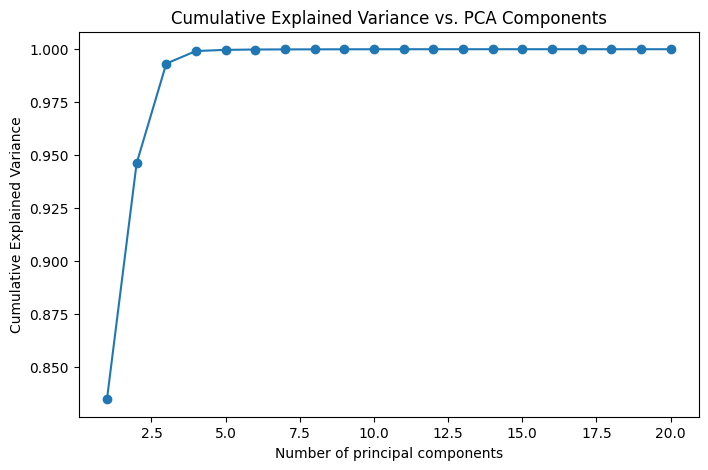

In [ ]:
pca = PCA()
pca.fit(X)
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8,5))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o', linestyle='-')
plt.title('Cumulative Explained Variance vs. PCA Components')
plt.xlabel('Number of principal components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

PCA and Logistic Regression (Accuracy: 58.6%)



In [ ]:
# PCA and LogReg

scaler = StandardScaler()
pca = PCA(n_components=5)
lr = LogisticRegression(multi_class='multinomial',
                        solver='lbfgs',
                        max_iter=1000)

pipe = Pipeline(steps=[('Scale',scaler), ('PCA',pca), ('LogReg',lr)])
pipe.fit(X_train,y_train)
# y_pred = pipe.predict(X_test)

print('PCA and Logistic Regression on col_housing_merged:')
log_acc = pipe.score(X_test, y_test)
print("Accuracy:", log_acc)

PCA and Logistic Regression on col_housing_merged:
Accuracy: 0.5621024967148489


PCA and Random Forest Classifier (Accuracy: 70.5%)

In [ ]:
# PCA and Random Forest

scaler = StandardScaler()
pca = PCA(n_components=5)
rf = RandomForestClassifier(class_weight='balanced',
                            criterion='entropy',
                            n_estimators=150,
                            max_depth=30,
                            random_state=42)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_pca, y_train)

y_pred = rf.predict(X_test_pca)

print('Random Forest Classifier with PCA on col_housing_merged')
rf_acc = rf.score(X_test_pca, y_test)
print("Accuracy:", rf_acc)
rf_confusion = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(rf_confusion)

Random Forest Classifier with PCA on col_housing_merged
Accuracy: 0.7053350854139291
Confusion Matrix:
[[2022  553   90   14    8]
 [ 534 3250  673  116   24]
 [  78  720 2735  701   81]
 [  22  128  682 2519  559]
 [   3   31   86  503 2893]]


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.76      0.75      0.76      2687
         2.0       0.69      0.71      0.70      4597
         3.0       0.64      0.63      0.64      4315
         4.0       0.65      0.64      0.65      3910
         5.0       0.81      0.82      0.82      3516

    accuracy                           0.71     19025
   macro avg       0.71      0.71      0.71     19025
weighted avg       0.70      0.71      0.71     19025



In [ ]:
pca.explained_variance_ratio_

array([8.35157665e-01, 1.10999740e-01, 4.70855476e-02, 5.90601088e-03,
       5.46917906e-04])

Random Forest Classifier only (Accuracy: 77.1%)

In [ ]:
# Random Forest WITHOUT PCA

rfc = RandomForestClassifier(n_estimators=150,
                             class_weight='balanced',
                             criterion='entropy',
                             max_depth=30,
                             random_state=42)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

print('Random Forest Classifier on col_housing_merged')
rf_acc = rfc.score(X_test, y_test)
print("Accuracy:", rf_acc)
rf_confusion = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(rf_confusion)

Random Forest Classifier on col_housing_merged
Accuracy: 0.7707227332457293
Confusion Matrix:
[[2105  521   47   11    3]
 [ 407 3531  598   56    5]
 [  22  546 3109  598   40]
 [   7   53  555 2862  433]
 [   6    8   29  417 3056]]


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         1.0       0.83      0.78      0.80      2687
         2.0       0.76      0.77      0.76      4597
         3.0       0.72      0.72      0.72      4315
         4.0       0.73      0.73      0.73      3910
         5.0       0.86      0.87      0.87      3516

    accuracy                           0.77     19025
   macro avg       0.78      0.77      0.78     19025
weighted avg       0.77      0.77      0.77     19025



Feature Importances from Random Forest Classification

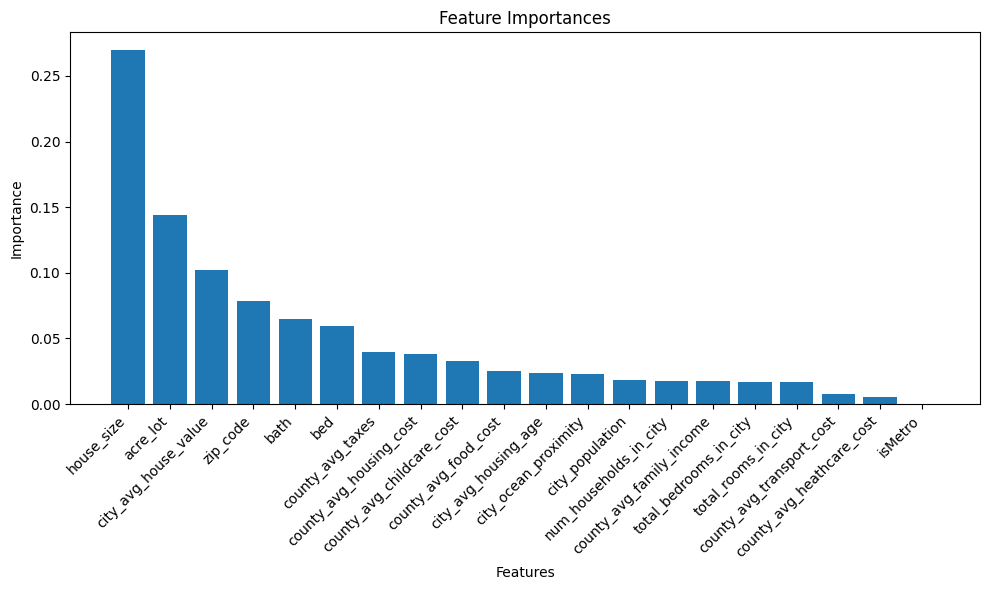

In [ ]:
feature_importances = rfc.feature_importances_
features = X.columns

ind = np.argsort(feature_importances)[::-1]
feature_names = [features[i] for i in ind]
importances = feature_importances[ind]

plt.figure(figsize=(10, 6))
plt.bar(feature_names, importances)

plt.title('Feature Importances')
plt.ylabel('Importance')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()

# Challenges and Obstacles Faced



*   Each dataset has a unique set of columns and keys, making it challenging to identify a common key for merging and combining the two datasets.
*   Some datasets are large, and merging too many features can sometimes lead to out-of-memory issues.
*   Searching for certain datasets was very difficult since some were behind a paywall or from a private company.



# Next Steps / Future Direction



*   So far we only focused on the Bay Area compared to the US, in the future we could compare Bay Area cities to other major cities in other countries

*   We could also explore other main cities in the US beside the Bay area such as Hawaii area, DC area, or New York area

*   We could convert currency to balance out housing prices in USD for those other countries

*    We could also run additional model to try to get better results

